In [1]:
import os 
from dotenv import load_dotenv 
env_path = "./config/.env" 
load_dotenv(dotenv_path=env_path) 
api_key = os.getenv("GOOGLE_API_KEY") 
# print(api_key)

**Table of contents**<a id='toc0_'></a>    
- [Data Mining Lab 2 - Phase 2](#toc1_)    
  - [Before Starting](#toc1_1_)    
  - [Introduction](#toc1_2_)    
  - [**1. Data Preparation**](#toc1_3_)    
  - [**1.1 Load data**](#toc1_4_)    
    - [**1.2 Save data**](#toc1_4_1_)    
  - [**2. Large Language Models (LLMs)**](#toc1_5_)    
    - [Open-Source vs. Proprietary LLMs](#toc1_5_1_)    
    - [Why Use Code (API) for Data Mining?](#toc1_5_2_)    
    - [The Gemini API](#toc1_5_3_)    
    - [Interacting with the Gemini API](#toc1_5_4_)    
    - [**2.1 Text Prompting**](#toc1_5_5_)    
        - [**>>> Exercise 1 (Take home):**](#toc1_5_5_1_1_)    
    - [**2.2 Structured Output**](#toc1_5_6_)    
        - [**>>> Exercise 2 (Take home):**](#toc1_5_6_1_1_)    
    - [**2.3 Information Extraction and Grounding:**](#toc1_5_7_)    
      - [**`langextract`: A Library for Grounded Extraction**](#toc1_5_7_1_)    
        - [**2.3.1 Using PDF Documents:**](#toc1_5_7_1_1_)    
        - [**>>> Bonus Exercise 3 (Take home):**](#toc1_5_7_1_2_)    
    - [**2.4 Generating LLM Embeddings:**](#toc1_5_8_)    
        - [**>>> Exercise 4 (Take home):**](#toc1_5_8_1_1_)    
    - [**2.5 Retrieval-Augmented Generation (RAG)**](#toc1_5_9_)    
        - [**Actual answer in the URL:**](#toc1_5_9_1_1_)    
        - [**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc1_5_9_1_2_)    
        - [**>>> Bonus Exercise 5 (Take home):**](#toc1_5_9_1_3_)    
    - [**2.6 Few-Shot Prompting Classification:**](#toc1_5_10_)    
        - [**>>> Exercise 6 (Take home):**](#toc1_5_10_1_1_)    
        - [**>>> Exercise 7 (Take home):**](#toc1_5_10_1_2_)    
    - [**2.7 Extra LLM Related Materials:**](#toc1_5_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Data Mining Lab 2 - Phase 2](#toc0_)
In this lab's phase 2 session we will focus on exploring some basic LLMs' applications with data.


## <a id='toc1_1_'></a>[Before Starting](#toc0_)

**Make sure you have installed all the required libraries and you have the environment ready to run this lab.**
    

---
## <a id='toc1_2_'></a>[Introduction](#toc0_)

**Dataset:** [SemEval 2017 Task](https://competitions.codalab.org/competitions/16380)

**Task:** Classify text data into 4 different emotions using word embeddings and other deep information retrieval approaches.

![pic0.png](./pics/pic0.png)

---
## <a id='toc1_3_'></a>[**1. Data Preparation**](#toc0_)

---
## <a id='toc1_4_'></a>[**1.1 Load data**](#toc0_)

We start by loading the csv files into a single pandas dataframe for training and one for testing.

In [2]:
import pandas as pd

### training data
anger_train = pd.read_csv("data/semeval/train/anger-ratings-0to1.train.txt",
                         sep="\t", header=None,names=["id", "text", "emotion", "intensity"])
sadness_train = pd.read_csv("data/semeval/train/sadness-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_train = pd.read_csv("data/semeval/train/fear-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_train = pd.read_csv("data/semeval/train/joy-ratings-0to1.train.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

In [3]:
# combine 4 sub-dataset
train_df = pd.concat([anger_train, fear_train, joy_train, sadness_train], ignore_index=True)

In [4]:
### testing data
anger_test = pd.read_csv("data/semeval/dev/anger-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
sadness_test = pd.read_csv("data/semeval/dev/sadness-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
fear_test = pd.read_csv("data/semeval/dev/fear-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])
joy_test = pd.read_csv("data/semeval/dev/joy-ratings-0to1.dev.gold.txt",
                         sep="\t", header=None, names=["id", "text", "emotion", "intensity"])

# combine 4 sub-dataset
test_df = pd.concat([anger_test, fear_test, joy_test, sadness_test], ignore_index=True)
train_df.head()

,id,text,emotion,intensity
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896


In [5]:
# shuffle dataset
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [6]:
print("Shape of Training df: ", train_df.shape)
print("Shape of Testing df: ", test_df.shape)

Shape of Training df:  (3613, 4)
Shape of Testing df:  (347, 4)


---
### <a id='toc1_4_1_'></a>[**1.2 Save data**](#toc0_)

In [7]:
# save to pickle file
train_df.to_pickle("./data/train_df.pkl") 
test_df.to_pickle("./data/test_df.pkl")

In [8]:
import pandas as pd

# load a pickle file
train_df = pd.read_pickle("./data/train_df.pkl")
test_df = pd.read_pickle("./data/test_df.pkl")

For more information: https://reurl.cc/0Dzqx

---
## <a id='toc1_5_'></a>[**2. Large Language Models (LLMs)**](#toc0_)

Before we start we strongly suggest that you watch the following video explanations so you can understand the concepts that we are gonna discuss about LLMs: 

1. [How Large Language Models Work](https://www.youtube.com/watch?v=5sLYAQS9sWQ)
2. [Large Language Models explained briefly](https://www.youtube.com/watch?v=LPZh9BOjkQs)
3. [What is Prompt Tuning?](https://www.youtube.com/watch?v=yu27PWzJI_Y)
4. [Why Large Language Models Hallucinate](https://www.youtube.com/watch?v=cfqtFvWOfg0)
5. [What are LLM Embeddings?](https://www.youtube.com/watch?v=UShw_1NbpCw&t=182s)
6. [What is Retrieval-Augmented Generation (RAG)?](https://www.youtube.com/watch?v=T-D1OfcDW1M)
7. [RAG vs Fine-Tuning vs Prompt Engineering: Optimizing AI Models](https://www.youtube.com/watch?v=zYGDpG-pTho)
8. [Discover Few-Shot Prompting | Google AI Essentials](https://www.youtube.com/watch?v=9qdgEBVkWR4)
9. [What is Zero-Shot Learning?](https://www.youtube.com/watch?v=pVpr4GYLzAo)
10. [Zero-shot, One-shot and Few-shot Prompting Explained | Prompt Engineering 101](https://www.youtube.com/watch?v=sW5xoicq5TY)

`These videos can help you get a better grasp on the core concepts of LLMs if you were not familiar before.`

**So now let's start with the main content of Lab 2 Phase 2.**

Large Language Models (LLMs) are AI systems trained on vast amounts of text to understand and generate human language for tasks like summarization and translation.

### <a id='toc1_5_1_'></a>[Open-Source vs. Proprietary LLMs](#toc0_)
*   **Open-Source Models** (e.g., Llama, Gemma) are customizable and cost-effective but require technical skill to manage and may be less powerful.
*   **Proprietary Models** (e.g., Gemini, ChatGPT) offer top performance and ease of use but are more costly and less flexible.

For students interested in running models locally, the optional notebook `DM2025-Lab2-Optional-Ollama.ipynb` explores using Ollama ([Ollama GitHub Link](https://github.com/ollama/ollama)). It needs a capable GPU to run models (**at least 4GB VRAM**).

You can explore the variety of models available through Ollama here:

![pic10.png](./pics/pic10.png)

### <a id='toc1_5_2_'></a>[Why Use Code (API) for Data Mining?](#toc0_)

For data analysis, accessing LLMs programmatically is superior to using web chatbots because it allows for:
*   **Automation:** Easily process entire datasets with loops.
*   **Structured Output:** Receive data in usable formats like **JSON**, ready for analysis in tools like pandas.
*   **Reproducibility:** Ensure consistent results by setting fixed parameters.
*   **Privacy:** Maintain data security, especially when running models locally.

For the main exercises in this lab, we will use **the Gemini API**. This approach offers several advantages over running local open-source models, such as access to state-of-the-art model performance without needing specialized hardware. While the API has usage limits (rate limits and token quotas), it provides a generous **free tier** that is more than sufficient for our exercises.

![pic13.png](./pics/pic13.png)

![pic14.png](./pics/pic14.png)

### <a id='toc1_5_3_'></a>[The Gemini API](#toc0_)

We will primarily use the **Gemini 2.5 Flash-Lite** (`gemini-2.5-flash-lite`) model. As shown in the rate limit table, this model is optimized for high-frequency tasks and offers a high request-per-day limit of 1,000, making it ideal for completing the lab exercises without interruption.

Students are encouraged to explore other models available through the API but should remain mindful of their respective usage limits. For instance:
*   **Gemini 2.5 Pro** is a more powerful model but has a lower daily request limit of 100.
*   The **Gemma 3** model available via the API offers an impressive 14,400 requests per day, providing another excellent alternative for experimentation.

Please be aware of your usage limits as you work through the exercises to ensure you do not get rate-limited.

[Gemini Documentation](https://ai.google.dev/gemini-api/docs)

[Gemini Rate Limits](https://ai.google.dev/gemini-api/docs/rate-limits)

[Description of Gemini Models](https://ai.google.dev/gemini-api/docs/models)

---

### <a id='toc1_5_4_'></a>[Interacting with the Gemini API](#toc0_)

The code cell below contains the primary function, `prompt_gemini`, that we will use throughout this lab to communicate with the Gemini API. It's designed to be a flexible wrapper that handles the details of sending a request and receiving a response.

Before you run the exercises, here are the key things you need to understand in this setup:

*   **API Key Configuration**: The script loads your API key from a `.env` file located in the `./config/` directory. **You must create this file and add your API key** like this: `GOOGLE_API_KEY='YOUR_API_KEY_HERE'`. This is a security best practice to keep your credentials out of the code.

*   **Global Settings**: At the top of the script, you can find and modify several important defaults:
    *   `MODEL_NAME`: We've set this to `"gemini-2.5-flash-lite"`, but you can easily switch to other models like `"gemini-2.5-pro"` to experiment.
    *   `SYSTEM_INSTRUCTION`: This sets the model's default behavior or persona (e.g., "You are a helpful assistant"). You can customize this for different tasks.
    *   `SAFETY_SETTINGS`: For our academic exercises, these are turned off to prevent interference. In real-world applications, you would configure these carefully.

*   **The `prompt_gemini` function**: This is the main tool you will use. Here are its most important parameters:
    *   `input_prompt`: The list of contents (text, images, etc.) you want to send to the model.
    *   `temperature`: Controls the randomness of the output. `0.0` makes the output deterministic and less creative, while a higher value (e.g., `0.7`) makes it more varied.
    *   `schema`: A powerful feature that allows you to specify a JSON format for the model's output. This is extremely useful for structured data extraction.
    *   `with_tokens_info`: If set to `True`, the function will also return the number of input and output tokens used, which is helpful for monitoring your usage against the free tier limits.

In the following exercises, you will call this function with different prompts and configurations to solve various tasks.

If needed, you can also check some tutorials on how a python function works: [Python Functions Tutorial](https://realpython.com/defining-your-own-python-function/)

In [9]:
import os
from dotenv import load_dotenv
from google import genai
from google.genai import types

env_path = "./config/.env"
load_dotenv(dotenv_path=env_path)

# System instruction that can dictate how the model behaves in the output, can be customized as needed
SYSTEM_INSTRUCTION = (
        "You are a helpful assistant"
    )

# Max amount of tokens that the model can output, the Gemini 2.5 Models have this maximum amount
# For other models need to check their documentation 
MAX_OUTPUT_TOKENS = 65535
MODEL_NAME = "gemini-2.5-flash-lite" # Other models: "gemini-2.5-pro", "gemini-2.5-flash"; Check different max output tokens: "gemini-2.0-flash" , "gemini-2.0-flash-lite" 

# We disable the safety settings, as no moderation is needed in our tasks
SAFETY_SETTINGS = [
    types.SafetySetting(
        category="HARM_CATEGORY_HATE_SPEECH", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_SEXUALLY_EXPLICIT", threshold="OFF"),
    types.SafetySetting(
        category="HARM_CATEGORY_HARASSMENT", threshold="OFF")
]

#IMPORTANT: The script loads your API key from a `.env` file located in the `./config/` directory. 
# You must create this file and add your API key like this: `GOOGLE_API_KEY='YOUR_API_KEY_HERE'`

# We input the API Key to be able to use the Gemini models
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key
client = genai.Client(api_key=api_key)

# We also set LangExtract to use the API key as well:
if 'GEMINI_API_KEY' not in os.environ:
    os.environ['GEMINI_API_KEY'] = api_key

def prompt_gemini(
        input_prompt: list,
        schema = None,
        temperature: float = 0.0,
        system_instruction: str = SYSTEM_INSTRUCTION,
        max_output_tokens: int = MAX_OUTPUT_TOKENS,
        client: genai.Client = client,
        model_name: str = MODEL_NAME,
        new_config: types.GenerateContentConfig = None,
        with_tools: bool = False,
        with_parts: bool = False,
        with_tokens_info: bool = False
    ):
        try:
            # If we need a JSON schema we set up the following
            if schema:
                generate_content_config = types.GenerateContentConfig(
                    temperature=temperature,
                    system_instruction=system_instruction,
                    max_output_tokens=max_output_tokens,
                    response_modalities=["TEXT"],
                    response_mime_type="application/json",
                    response_schema=schema,
                    safety_settings=SAFETY_SETTINGS
                )
            # If there is no need we leave it unstructured
            else:
                generate_content_config = types.GenerateContentConfig(
                    temperature=temperature,
                    system_instruction=system_instruction,
                    max_output_tokens=max_output_tokens,
                    response_modalities=["TEXT"],
                    safety_settings=SAFETY_SETTINGS
                )
            
            # We add a different custom configuration if we need it
            if new_config:
                generate_content_config = new_config
            
            # For some tasks we need a more specific way to add the contents when prompting the model
            # So we need custom parts for it sometimes from the "types" objects
            if with_parts:
                response = client.models.generate_content(
                    model=model_name,
                    contents=types.Content(parts=input_prompt),
                    config=generate_content_config,
                )
            # In the simplest form the contents can be expressed as a list [] of simple objects like str and Pillow images
            else:
                response = client.models.generate_content(
                    model=model_name,
                    contents=input_prompt,
                    config=generate_content_config,
                )

            if with_tools:
                # print(response)
                # Include raw response when function calling
                completion = response
                if with_tokens_info:
                    log = {
                        "model": model_name,
                        "input_tokens": response.usage_metadata.prompt_token_count,
                        "output_tokens": response.usage_metadata.candidates_token_count,
                    }
                    return completion, log
                return completion
            else:
                completion = response.text
                if with_tokens_info:
                    log = {
                        "model": model_name,
                        "input_tokens": response.usage_metadata.prompt_token_count,
                        "output_tokens": response.usage_metadata.candidates_token_count,
                    }
                    # Return the text response and logs (if selected)
                    return completion, log
                return completion
        except Exception as e:
             print(f"Error occurred when generating response, error: {e}")
             return None

---
### <a id='toc1_5_5_'></a>[**2.1 Text Prompting**](#toc0_)

In the same way as with ChatGPT we can use the Gemini models to ask about anything. Here we are going to ask a question requesting the response to be in markdown format, this is to make it have a better display afterwards.

For more information visit:
[Gemini's Text Generation Documentation](https://ai.google.dev/gemini-api/docs/text-generation)

In [10]:
input_prompt = ["What is Data Mining?"]
text_response, logs = prompt_gemini(input_prompt = input_prompt, with_tokens_info = True)
print(text_response)

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strat

We can also check the logs of the usage with our model that we defined in our previous function. We can observe the model we used, how many tokens where in the prompt in the input, and the output text response tokens of our model.

In [11]:
print(logs)

{'model': 'gemini-2.5-flash-lite', 'input_tokens': 12, 'output_tokens': 911}


**We can use the IPython library to make the response look better:**

In [12]:
from IPython.display import display, Markdown
display(Markdown(text_response))

Data mining is the process of **discovering patterns, insights, and knowledge from large datasets**. It's essentially about extracting valuable information that isn't immediately obvious from raw data. Think of it as sifting through a mountain of information to find hidden gems.

Here's a breakdown of what that means:

**Key Concepts:**

*   **Large Datasets:** Data mining is typically applied to datasets that are too large and complex for manual analysis. This can include customer transaction records, website logs, sensor data, social media feeds, scientific experiment results, and much more.
*   **Patterns and Insights:** The goal is to identify recurring trends, correlations, anomalies, and relationships within the data. These patterns can reveal underlying structures, predict future behavior, or explain observed phenomena.
*   **Knowledge Discovery:** The ultimate aim is to transform raw data into actionable knowledge that can be used for decision-making, problem-solving, and strategic planning.

**How it Works (The Process):**

Data mining is usually an iterative process that involves several stages:

1.  **Business Understanding:** Defining the problem or objective you want to achieve with data mining. What questions are you trying to answer? What business goals are you trying to meet?
2.  **Data Understanding:** Exploring and getting familiar with the data. This involves collecting, cleaning, and understanding the data's structure, quality, and meaning.
3.  **Data Preparation (Preprocessing):** This is often the most time-consuming stage. It involves:
    *   **Cleaning:** Handling missing values, noisy data, and inconsistencies.
    *   **Integration:** Combining data from multiple sources.
    *   **Transformation:** Normalizing or aggregating data to make it suitable for mining.
    *   **Reduction:** Reducing the size of the dataset while preserving important information.
4.  **Modeling:** Selecting and applying appropriate data mining techniques (algorithms) to discover patterns. This is where the "mining" happens.
5.  **Evaluation:** Assessing the quality and usefulness of the discovered patterns. Do they make sense? Are they statistically significant? Do they meet the business objectives?
6.  **Deployment:** Putting the discovered knowledge into practice. This could involve integrating it into business processes, creating reports, or building predictive models.

**Common Data Mining Techniques:**

Data mining employs a variety of techniques, often drawing from statistics, machine learning, and database systems. Some of the most common include:

*   **Classification:** Categorizing data into predefined classes (e.g., predicting whether a customer will churn or not).
*   **Clustering:** Grouping similar data points together without predefined classes (e.g., segmenting customers into different groups based on their purchasing behavior).
*   **Association Rule Mining:** Discovering relationships between items in a dataset (e.g., "customers who buy bread also tend to buy milk"). This is often used in market basket analysis.
*   **Regression:** Predicting a continuous numerical value (e.g., predicting the price of a house based on its features).
*   **Anomaly Detection (Outlier Detection):** Identifying data points that deviate significantly from the norm (e.g., detecting fraudulent transactions).
*   **Sequential Pattern Mining:** Discovering patterns that occur in a sequence over time (e.g., identifying common user navigation paths on a website).

**Why is Data Mining Important?**

Data mining is crucial for businesses and organizations because it enables them to:

*   **Make Better Decisions:** By understanding customer behavior, market trends, and operational efficiencies, organizations can make more informed and strategic decisions.
*   **Improve Customer Relationships:** Identifying customer preferences and predicting their needs allows for personalized marketing, better customer service, and increased loyalty.
*   **Detect Fraud and Risk:** Anomaly detection can help identify fraudulent activities, security breaches, and potential risks.
*   **Optimize Operations:** Understanding patterns in operational data can lead to improved efficiency, reduced costs, and better resource allocation.
*   **Drive Innovation:** Discovering new insights can spark new product development, service offerings, and business models.
*   **Gain a Competitive Advantage:** Organizations that effectively leverage data mining can outperform their competitors by understanding their market and customers better.

In essence, data mining is a powerful tool for transforming raw data into valuable intelligence, driving progress and innovation across various fields.

---
##### <a id='toc1_5_5_1_1_'></a>[**>>> Exercise 1 (Take home):**](#toc0_)

`With your own prompt`, run the previous example in the following way:

1. Run it with the same model as the example (gemini-2.5-flash-lite). 
2. Run it with a different gemini model from the available options for the API.
3. Discuss the differences on the results with different models.
4. Discuss what would happen if you change the system prompt.


In [13]:

# Step 1: Import required libraries
import os
from dotenv import load_dotenv
from google import genai
from google.genai import types
from IPython.display import display, Markdown

# Step 2: Load environment variables
env_path = "./config/.env"
load_dotenv(dotenv_path=env_path)

# Step 3: Basic configuration
SYSTEM_INSTRUCTION = "You are a helpful assistant"
MAX_OUTPUT_TOKENS = 65535
SAFETY_SETTINGS = [
    types.SafetySetting(category="HARM_CATEGORY_HATE_SPEECH", threshold="OFF"),
    types.SafetySetting(category="HARM_CATEGORY_DANGEROUS_CONTENT", threshold="OFF"),
    types.SafetySetting(category="HARM_CATEGORY_SEXUALLY_EXPLICIT", threshold="OFF"),
    types.SafetySetting(category="HARM_CATEGORY_HARASSMENT", threshold="OFF")
]

# Step 4: Initialize Gemini client
api_key = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = api_key
client = genai.Client(api_key=api_key)
if 'GEMINI_API_KEY' not in os.environ:
    os.environ['GEMINI_API_KEY'] = api_key

# Step 5: Define helper function for prompting Gemini
def prompt_gemini(
        input_prompt: list,
        schema=None,
        temperature: float = 0.0,
        system_instruction: str = SYSTEM_INSTRUCTION,
        max_output_tokens: int = MAX_OUTPUT_TOKENS,
        client: genai.Client = client,
        model_name: str = "gemini-2.5-flash-lite",
        new_config: types.GenerateContentConfig = None,
        with_tools: bool = False,
        with_parts: bool = False,
        with_tokens_info: bool = False
    ):

    try:
        if schema:
            generate_content_config = types.GenerateContentConfig(
                temperature=temperature,
                system_instruction=system_instruction,
                max_output_tokens=max_output_tokens,
                response_modalities=["TEXT"],
                response_mime_type="application/json",
                response_schema=schema,
                safety_settings=SAFETY_SETTINGS
            )
        else:
            generate_content_config = types.GenerateContentConfig(
                temperature=temperature,
                system_instruction=system_instruction,
                max_output_tokens=max_output_tokens,
                response_modalities=["TEXT"],
                safety_settings=SAFETY_SETTINGS
            )
                  
        if new_config:
            generate_content_config = new_config
        
        if with_parts:
            response = client.models.generate_content(
                model=model_name,
                contents=types.Content(parts=input_prompt),
                config=generate_content_config,
            )
        else:
            response = client.models.generate_content(
                model=model_name,
                contents=input_prompt,
                config=generate_content_config,
            )

        completion = response.text
        if with_tokens_info:
            log = {
                "model": model_name,
                "input_tokens": response.usage_metadata.prompt_token_count,
                "output_tokens": response.usage_metadata.candidates_token_count,
            }
            return completion, log
        return completion
    except Exception as e:
        print(f"Error occurred when generating response: {e}")
        return None

Both GOOGLE_API_KEY and GEMINI_API_KEY are set. Using GOOGLE_API_KEY.


In [14]:
# Step 6: Define your own prompt
input_prompt = ["Explain why machine learning models need training data."]

# --- Run with gemini-2.5-flash-lite ---
model_name_1 = "gemini-2.5-flash-lite"
response_1, log_1 = prompt_gemini(
    input_prompt=input_prompt,
    model_name=model_name_1,
    with_tokens_info=True
)
print(f"\n=== Response from {model_name_1} ===\n")
display(Markdown(response_1))
print(f"Tokens used: {log_1}")

# --- Run with gemini-2.5-pro ---
model_name_2 = "gemini-2.5-pro"
response_2, log_2 = prompt_gemini(
    input_prompt=input_prompt,
    model_name=model_name_2,
    with_tokens_info=True
)
print(f"\n=== Response from {model_name_2} ===\n")
display(Markdown(response_2))
print(f"Tokens used: {log_2}")

# --- Run again with modified system prompt ---
new_system_prompt = "You are a university professor. Answer in a formal, academic style."
response_3, log_3 = prompt_gemini(
    input_prompt=input_prompt,
    model_name=model_name_1,
    system_instruction=new_system_prompt,
    with_tokens_info=True
)
print("\n=== Response with Modified System Prompt (Academic Tone) ===\n")
display(Markdown(response_3))
print(f"Tokens used: {log_3}")



=== Response from gemini-2.5-flash-lite ===



Machine learning models need training data because they are essentially **learning from examples**. Unlike traditional programming where you explicitly write rules for every scenario, machine learning models are designed to **discover patterns and relationships** within data. Training data serves as the "textbook" or "teacher" that guides this learning process.

Here's a breakdown of why training data is crucial:

**1. Pattern Recognition and Feature Extraction:**

*   **Identifying Underlying Structures:** Training data allows the model to identify recurring patterns, correlations, and underlying structures within the input features. For example, in an image recognition model, training data with many pictures of cats helps it learn what features (e.g., pointy ears, whiskers, specific eye shape) are characteristic of a cat.
*   **Learning Relevant Features:** The model learns which features are most important for making accurate predictions. It can distinguish between noise and meaningful information.

**2. Generalization to New, Unseen Data:**

*   **The Goal of Learning:** The ultimate goal of a machine learning model is to perform well on data it has never encountered before. Training data provides the foundation for this generalization.
*   **Avoiding Memorization:** If a model were to simply memorize the training data, it would be useless in real-world scenarios where new data is constantly generated. Training helps the model learn the underlying principles rather than just specific instances.

**3. Parameter Optimization:**

*   **Adjusting Internal Settings:** Machine learning models have internal parameters (weights and biases in neural networks, coefficients in linear regression, etc.) that determine their behavior. Training data is used to iteratively adjust these parameters.
*   **Minimizing Errors:** The training process involves feeding the data to the model, comparing its predictions to the actual outcomes (labels), and then adjusting the parameters to minimize the difference (error). This is often done using optimization algorithms like gradient descent.

**4. Learning Complex Relationships:**

*   **Beyond Simple Rules:** For complex problems, it's impossible or impractical to define explicit rules. Machine learning excels at learning these intricate, non-linear relationships that might be too subtle for humans to codify.
*   **Example:** Predicting stock prices involves a multitude of interacting factors. Training data allows a model to learn these complex dependencies.

**5. Building a Predictive or Decision-Making Capability:**

*   **The "Brain" of the Model:** The trained model essentially becomes a learned function that can take new inputs and produce outputs (predictions, classifications, recommendations, etc.).
*   **Actionable Insights:** This learned capability allows the model to be used for various applications, from recommending products to diagnosing diseases.

**Analogy:**

Imagine teaching a child to identify different animals. You wouldn't just give them a list of rules. Instead, you would show them pictures of dogs, cats, birds, etc., and tell them what each animal is. The child learns by observing these examples, noticing common features, and eventually being able to identify new animals they haven't seen before. Training data for a machine learning model works in a very similar way.

**In summary, training data is the fuel that powers machine learning. Without it, the model has no basis for learning, no way to understand the problem it's supposed to solve, and no ability to make accurate predictions on new data.** The quality, quantity, and diversity of the training data directly impact the performance and reliability of the trained machine learning model.

Tokens used: {'model': 'gemini-2.5-flash-lite', 'input_tokens': 16, 'output_tokens': 713}

=== Response from gemini-2.5-pro ===



Of course! This is a fundamental concept in machine learning. Here’s a detailed explanation, starting with a simple analogy and then diving into the technical reasons.

### The Core Analogy: Teaching a Child

Imagine you're teaching a small child to identify a **cat**. You wouldn't just give them a dictionary definition like "a small domesticated carnivorous mammal with soft fur, a short snout, and retractable claws." That's too abstract.

Instead, you would show them examples:
*   You point to your pet and say, "**That is a cat.**"
*   You show them a picture in a book and say, "**That's also a cat.**"
*   You point to a dog and say, "**That is a dog, *not* a cat.**"

Through these examples (the **data**), the child's brain starts to learn the patterns, features, and variations associated with "cat-ness"—the pointy ears, the whiskers, the way they move, the sounds they make. They build an internal, flexible concept of what a cat is.

**A machine learning model learns in the exact same way.** The **training data** is the collection of examples (pictures, sounds, text) that we show the model so it can learn to build its own internal concept.

---

### What is Training Data?

Training data is a large dataset of examples used to "teach" a machine learning model. For most common tasks (called supervised learning), each piece of data has two parts:

1.  **Input Features:** The raw information you want the model to learn from (e.g., the pixels of an image, the words in an email, the square footage of a house).
2.  **Correct Output (Label or Target):** The right answer that corresponds to the input (e.g., the label "cat," the classification "spam," the price of the house).

The training data is essentially an **answer key** that the model uses to learn.

---

### Why Models *Need* This Data: The Four Key Reasons

Machine learning models are not programmed with explicit rules like traditional software. A traditional spam filter might have a rule like: `IF email contains "free money" THEN mark as spam`. This is brittle and easy to evade.

An ML model, however, *infers* the rules from data. Here’s why that data is essential.

#### 1. To Learn Patterns and Relationships

The primary goal of a model is to find hidden patterns and complex relationships within data that a human might miss or be unable to define.

*   **Example (House Price Prediction):** A model is given data for 10,000 houses, including features like square footage, number of bedrooms, and location (inputs), along with their final sale price (output). By analyzing this training data, the model learns the complex relationship between these features and the price. It learns that *generally* more bedrooms increase the price, but that a good location can be even more important. It learns these "rules" by itself, without being explicitly programmed.

#### 2. To Build an Internal Representation (The "Model" Itself)

The "learning" process is actually a mathematical optimization. A model starts as a generic, untrained algorithm—a blank slate. It's essentially a complex equation with millions of internal numbers, called **parameters** or **weights**.

During training, the model does the following, over and over:
1.  Takes an example from the training data (e.g., a picture of a cat).
2.  Makes a guess (e.g., "I'm 60% sure this is a dog").
3.  Compares its guess to the correct label ("cat").
4.  Calculates its **error** (how wrong it was).
5.  Slightly adjusts its internal parameters to reduce that error for the next time.

The training data provides the **ground truth** necessary to calculate this error and guide the adjustments. After seeing thousands or millions of examples, the model's parameters are tuned to a state where it can accurately recognize patterns. This final set of tuned parameters *is* the trained model.

#### 3. To Generalize to New, Unseen Data

The ultimate goal is not for the model to memorize the training data. We want it to perform well on **new data it has never seen before**.

If a model is trained on a diverse and large dataset of cat images (different breeds, angles, lighting), it doesn't just memorize those specific pictures. It learns the underlying *concept* of a cat. This ability to apply learned knowledge to new situations is called **generalization**.

Without sufficient and varied training data, the model can't generalize. For example, if you only train it on pictures of orange tabby cats, it will likely fail to recognize a black Siamese cat.

#### 4. To Avoid Human Bias and Explicit Rule-Making

For many problems, the rules are too complex for a human to write down.
*   How would you write a program to recognize a human face? There are billions of faces, all different, with varying expressions, lighting, and angles.
*   How would you define the "style" of an author or the "sentiment" of a sentence?

Instead of trying to create these impossibly complex rules, we provide the model with labeled data and let it figure out the patterns on its own.

---

### The "Garbage In, Garbage Out" Principle

The quality and quantity of the training data are the most important factors in a model's success.

*   **Biased Data:** If your training data for hiring decisions only includes past successful candidates who were all from the same background, your model will learn to be biased against candidates from other backgrounds.
*   **Incorrect Data:** If you have pictures of cats mislabeled as dogs, the model will learn incorrectly.
*   **Insufficient Data:** If you don't have enough examples, the model won't be able to learn the patterns reliably and won't generalize well.

### Summary

In short, machine learning models need training data for the same reason a student needs textbooks and a teacher. The data provides the **examples, context, and feedback** necessary for the model to:

*   **Learn** the underlying patterns of a problem.
*   **Tune** its internal structure to accurately reflect those patterns.
*   **Generalize** its knowledge to make useful predictions on new, real-world data.

Without training data, a machine learning model is just an empty shell—a powerful but useless algorithm with no knowledge of the world.

Tokens used: {'model': 'gemini-2.5-pro', 'input_tokens': 16, 'output_tokens': 1403}

=== Response with Modified System Prompt (Academic Tone) ===



The necessity of training data for machine learning models stems from their fundamental operational paradigm: **learning from experience**. Unlike traditional, rule-based programming where explicit instructions are provided for every conceivable scenario, machine learning models are designed to **infer patterns, relationships, and decision boundaries from observed examples**. Training data serves as this crucial "experience" from which the model can generalize and make predictions on unseen data.

To elaborate, consider the core objective of most machine learning tasks: **prediction or classification**. A model aims to predict a target variable (e.g., house price, disease presence) or classify an input into a specific category (e.g., spam/not spam, image of a cat/dog). Without exposure to a representative set of inputs and their corresponding correct outputs, the model has no basis upon which to establish the mapping between the input features and the desired output.

Here are the key reasons why training data is indispensable:

*   **Pattern Recognition and Feature Extraction:** Machine learning algorithms are designed to identify underlying patterns and extract relevant features from the input data. For instance, in image recognition, a model learns to identify edges, textures, and shapes that collectively define an object. This learning process is entirely data-driven. The training data provides the raw material from which these patterns are discerned.

*   **Parameter Optimization:** Most machine learning models are parameterized systems. These parameters (often referred to as weights and biases in neural networks) are adjusted during the training process to minimize an error or loss function. The training data is used to calculate this error by comparing the model's predictions with the actual target values. The optimization algorithm then iteratively modifies the parameters to reduce this discrepancy. Without the ground truth provided by the training data, there is no error to minimize and no mechanism for parameter adjustment.

*   **Generalization:** The ultimate goal of a machine learning model is not merely to perform well on the data it has seen, but to generalize its learned knowledge to new, unseen data. Training data, when sufficiently diverse and representative of the real-world distribution, allows the model to learn robust patterns that are not specific to individual training examples but rather capture the underlying phenomena. This ability to generalize is what makes machine learning models useful in practical applications.

*   **Model Calibration and Validation:** Training data is also used to calibrate the model's confidence in its predictions. By observing how well the model performs on the training set, researchers and practitioners can gain insights into its capabilities and limitations. Furthermore, a portion of the training data is often set aside as a validation set to tune hyperparameters and monitor for overfitting, a phenomenon where the model becomes too specialized to the training data and performs poorly on new data.

*   **Learning Complex Relationships:** Many real-world problems involve intricate, non-linear relationships between variables that are difficult or impossible to explicitly define with rules. Machine learning models, through exposure to a large volume of training data, can learn these complex relationships implicitly. For example, predicting stock prices involves a multitude of interacting factors, and a model can learn these dependencies from historical market data.

In essence, training data acts as the **teacher** for the machine learning model. It provides the examples, the feedback, and the context necessary for the model to develop its predictive or analytical capabilities. The quality, quantity, and representativeness of this training data are paramount to the success and reliability of any machine learning endeavor. Without it, the model remains an uninitialized algorithm, incapable of performing its intended function.

Tokens used: {'model': 'gemini-2.5-flash-lite', 'input_tokens': 25, 'output_tokens': 711}


In [15]:
from IPython.display import display, Markdown

markdown_text = """
### **Differences Between Gemini Models**

- **`gemini-2.5-flash-lite`**: Gives short, fast, and efficient answers with less contextual detail.  
- **`gemini-2.5-pro`**: Produces longer, more detailed, and context-aware explanations.  
- **Summary**: *Flash-lite is optimized for speed; Pro is optimized for depth and reasoning.*

---

### **Effect of Changing the System Prompt**

- The **system prompt** controls the model’s tone and style.  
- `"You are a helpful assistant"` → conversational and neutral tone.  
- `"You are a university professor"` → formal, academic, and structured language.  
- **Summary**: Changing the system prompt alters *how* the model answers, not *what* it answers.
"""

display(Markdown(markdown_text))



### **Differences Between Gemini Models**

- **`gemini-2.5-flash-lite`**: Gives short, fast, and efficient answers with less contextual detail.  
- **`gemini-2.5-pro`**: Produces longer, more detailed, and context-aware explanations.  
- **Summary**: *Flash-lite is optimized for speed; Pro is optimized for depth and reasoning.*

---

### **Effect of Changing the System Prompt**

- The **system prompt** controls the model’s tone and style.  
- `"You are a helpful assistant"` → conversational and neutral tone.  
- `"You are a university professor"` → formal, academic, and structured language.  
- **Summary**: Changing the system prompt alters *how* the model answers, not *what* it answers.


---
### <a id='toc1_5_6_'></a>[**2.2 Structured Output**](#toc0_)

By default, an LLM responds with unstructured, free-form text. For data mining, this is often impractical, as we need data in a predictable format to load into tools like a pandas DataFrame for analysis. **Structured output** is a powerful feature that forces the model to return its response in a specific, machine-readable format, such as JSON.

The key to enabling this is to provide the model with a **response schema**. This schema acts as a strict template or blueprint that the model's output must conform to. Instead of generating a paragraph, the model will fill in the fields defined in your schema with the relevant information it extracts from the prompt.

In the following code, we define this schema using Python classes. Think of each class as defining a JSON object:
*   The **attributes** of the class (e.g., `topic_name`, `sub_title`) become the keys in the final JSON object.
*   The **type hints** for those attributes (e.g., `str`, `list`) tell the model what kind of data is expected for each key's value.

We can even nest these classes inside one another to create complex, hierarchical JSON structures. This allows us to precisely control the format of the output, transforming the LLM from a simple text generator into a reliable tool for automated and structured data extraction.

[Gemini's Structured Output Documentation](https://ai.google.dev/gemini-api/docs/structured-output)

For data validation of schemas Gemini API uses the Pydantic library, for more documentation on it you can check: [Pydantic](https://docs.pydantic.dev/latest/) 

[JSON Format Documentation](https://docs.python.org/3/library/json.html)

In [16]:
from pydantic import BaseModel

# We define our structure schema that Gemini should follow for the output response

# Subsections on the topics we query
class Subsection(BaseModel):
    sub_title: str
    sub_explanation: str

# The top-level structure for the entire topic analysis
class Topic(BaseModel):
    topic_name: str
    subsections: list[Subsection]

In [17]:
input_prompt = ["Explain what are machine learning, data centers, llms and how do they relate to each other."]
text_response = prompt_gemini(input_prompt = input_prompt, schema = list[Topic])
print(text_response)

[
  {
    "topic_name": "Machine Learning",
    "subsections": [
      {
        "sub_title": "Definition",
        "sub_explanation": "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."
      },
      {
        "sub_title": "Types of Machine Learning",
        "sub_explanation": "Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties)."
      },
      {
        "sub_title": "Applications",
        "sub_explanation": "ML is used in a wide range of applications, such as image recognition, natural language processing, recommend

In [18]:
import json

# Now the response can be parsed to a python object using the JSON dictionary structure loading
structured_resp = json.loads(text_response)
print(structured_resp)
print(type(structured_resp))

[{'topic_name': 'Machine Learning', 'subsections': [{'sub_title': 'Definition', 'sub_explanation': "Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention."}, {'sub_title': 'Types of Machine Learning', 'sub_explanation': 'Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties).'}, {'sub_title': 'Applications', 'sub_explanation': 'ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis.'}]}, {'topic_name': 'Data Centers', 'subs

In [19]:
# So now we have an object that we can explore/use in a pythonic way for our purposes
for topic in structured_resp:
    print(topic["topic_name"], "\n")
    # We can access each subsection as well
    for subsection in topic["subsections"]:
        print("\t", subsection["sub_title"], "\n")
        print("\t\t", subsection["sub_explanation"], "\n")


Machine Learning 

	 Definition 

		 Machine learning (ML) is a subset of artificial intelligence (AI) that focuses on building systems that can learn from and make decisions based on data. Instead of being explicitly programmed, ML algorithms use statistical techniques to enable systems to 'learn' from data, identify patterns, and make predictions or decisions without human intervention. 

	 Types of Machine Learning 

		 Common types include supervised learning (learning from labeled data), unsupervised learning (finding patterns in unlabeled data), and reinforcement learning (learning through trial and error with rewards and penalties). 

	 Applications 

		 ML is used in a wide range of applications, such as image recognition, natural language processing, recommendation systems, fraud detection, and medical diagnosis. 

Data Centers 

	 Definition 

		 A data center is a dedicated physical facility that an organization uses to house its critical IT infrastructure, including servers

##### <a id='toc1_5_6_1_1_'></a>[**>>> Exercise 2 (Take home):**](#toc0_)

Try a prompt with your own schema structure, it needs to be completely different to the example. It should show an intuitive way to represent the text output of the model based on the prompt you chose. See the documentation for reference: https://ai.google.dev/gemini-api/docs/structured-output

In [20]:
from pydantic import BaseModel
import json
from IPython.display import display, Markdown

# Each key point in the summary
class KeyPoint(BaseModel):
    idea: str
    example: str

# The overall summary structure
class ConceptSummary(BaseModel):
    concept_name: str
    main_definition: str
    importance_level: str
    key_points: list[KeyPoint]

# Define the input prompt
input_prompt = [
    "Explain the concept of Artificial Intelligence, including its definition, importance, and key examples in daily life. "
    "Provide 3 main key points with an example for each."
]

# Generate structured response using the schema
text_response = prompt_gemini(
    input_prompt=input_prompt,
    schema=ConceptSummary
)

# Parse JSON result to Python object
structured_resp = json.loads(text_response)
print(json.dumps(structured_resp, indent=2))  # Pretty print JSON
print(type(structured_resp))

# Display the structured data clearly
display(Markdown(f"## Concept: {structured_resp['concept_name']}"))
display(Markdown(f"**Definition:** {structured_resp['main_definition']}"))
display(Markdown(f"**Importance:** {structured_resp['importance_level']}"))

display(Markdown("### Key Points:"))
for kp in structured_resp["key_points"]:
    display(Markdown(f"- **Idea:** {kp['idea']}"))
    display(Markdown(f"  - *Example:* {kp['example']}"))


{
  "concept_name": "Artificial Intelligence (AI)",
  "main_definition": "Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning (the acquisition of information and rules for using the information), reasoning (using rules to reach approximate or definite conclusions), and self-correction.",
  "importance_level": "High",
  "key_points": [
    {
      "idea": "Automation of repetitive tasks",
      "example": "AI-powered chatbots can handle customer service inquiries, freeing up human agents for more complex issues. Robotic process automation (RPA) uses AI to automate mundane, rule-based tasks in businesses."
    },
    {
      "idea": "Enhanced decision-making",
      "example": "In finance, AI algorithms analyze vast amounts of market data to identify investment opportunities and predict stock price movements, aiding financial advisors in making better decisions."
    },
    {
    

## Concept: Artificial Intelligence (AI)

**Definition:** Artificial Intelligence (AI) refers to the simulation of human intelligence processes by machines, especially computer systems. These processes include learning (the acquisition of information and rules for using the information), reasoning (using rules to reach approximate or definite conclusions), and self-correction.

**Importance:** High

### Key Points:

- **Idea:** Automation of repetitive tasks

  - *Example:* AI-powered chatbots can handle customer service inquiries, freeing up human agents for more complex issues. Robotic process automation (RPA) uses AI to automate mundane, rule-based tasks in businesses.

- **Idea:** Enhanced decision-making

  - *Example:* In finance, AI algorithms analyze vast amounts of market data to identify investment opportunities and predict stock price movements, aiding financial advisors in making better decisions.

- **Idea:** Personalization and recommendation systems

  - *Example:* Streaming services like Netflix and Spotify use AI to analyze user viewing and listening habits to recommend movies, shows, and music tailored to individual preferences.

In [21]:
reflection = """
### Discussion

In this task, a custom schema (`ConceptSummary`) was created to represent complex information in a structured and readable way.
Instead of a general paragraph, the output is organized into:
- A main concept name and definition,
- Its importance level,
- A list of key ideas with examples.

This structure helps transform free-text responses into easily processable data for further analysis or visualization.
It demonstrates how Gemini can output JSON-compatible data that follows a clear logical hierarchy defined by the user.
"""

display(Markdown(reflection))


### Discussion

In this task, a custom schema (`ConceptSummary`) was created to represent complex information in a structured and readable way.
Instead of a general paragraph, the output is organized into:
- A main concept name and definition,
- Its importance level,
- A list of key ideas with examples.

This structure helps transform free-text responses into easily processable data for further analysis or visualization.
It demonstrates how Gemini can output JSON-compatible data that follows a clear logical hierarchy defined by the user.


---
### <a id='toc1_5_7_'></a>[**2.3 Information Extraction and Grounding:**](#toc0_)

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

When using LLMs to extract structured data from text, two main challenges arise:

1.  **Trust:** LLMs can "hallucinate" or invent information. We need to ensure the extracted data is accurate and comes directly from the source text.
2.  **Scalability:** We need a reliable way to extract complex information consistently from thousands of large, messy documents.

The solution to these challenges is **grounding**—the process of linking every piece of extracted data back to its specific origin in the source document. This creates a verifiable audit trail, building trust in the output.

---
#### <a id='toc1_5_7_1_'></a>[**`langextract`: A Library for Grounded Extraction**](#toc0_)

**`langextract`** is an open-source Python library from Google designed to create trustworthy data extraction pipelines. It uses LLMs to convert unstructured text into structured data with a focus on reliability and traceability.

**Key Features:**

*   **Precise Grounding:** Its core feature. It maps every extracted item to its exact character position in the original text, allowing for easy verification.
*   **Reliable Structured Output:** Uses examples (few-shot prompting) to ensure the LLM's output consistently follows a predefined format.
*   **Adaptable & No Fine-Tuning:** Can be adapted to any domain (e.g., legal, medical) simply by changing the examples and instructions, without needing to retrain a model.
*   **Handles Long Documents:** Built to process lengthy texts that might exceed an LLM's standard context window.
*   **Flexible LLM Support:** It is model-agnostic and works with various LLMs like Gemini, OpenAI models, and even local open-source models through Ollama.

**`Github repository:`** [langextract](https://github.com/google/langextract)

---

##### <a id='toc1_5_7_1_1_'></a>[**2.3.1 Using PDF Documents:**](#toc0_)

For PDF Document information extraction we are going to use the `pymupdf` library. Documentation: [pymupdf](https://pymupdf.readthedocs.io/en/latest/)

And then we are going to pass it on to langextract to get insights on the document's content.

We can also process documents using Gemini, for more information you can check their documentation: [Document Understanding](https://ai.google.dev/gemini-api/docs/document-processing)

In [22]:
import pymupdf
# Extract text from the PDF and format it for the prompt
# This is a review from the movie interstellar
pdf_path = "./data/documents/doc_example_review_interstellar.pdf"
formatted_text = ""
try:
    doc = pymupdf.open(pdf_path)
    # In case the PDF documents have more than one page, in this example it only has one
    for i, page in enumerate(doc):
        text = page.get_text("text")
        # Format follows the prompt's requirement: **Page X** """document's text"""
        formatted_text += f'**Page {i + 1}**\n'
        formatted_text += f'"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text = "Error: Could not process PDF file."

✓ Extracted text from './data/documents/doc_example_review_interstellar.pdf'


In [23]:
print(formatted_text)

**Page 1**
"""
Dan Baldwin
Group 4
Auteur Review - Interstellar 
I believe Christopher Nolan: the director behind the 2014 sci-ﬁ/adventure cinematic ‘Interstellar,’ 
to be a very intellectual and imaginative inventive talent.  
His style in his previous ﬁlms sets characters in epic unique locations, with gargantuan issues to 
face, and artistically impresses the audience with how the characters solve their problems. For 
example, in Nolan’s 2010 ﬁlm ‘Inception,’ he tackles the idea of dreams, and sets his characters 
diving through dreams within dreams within even more dreams to complete their goals. Because 
this idea is so farfetched, and dreams are a subject in which science has made little factual 
discovery in, Nolan is free to use his creativity to present ideas such as landscapes folding in on 
themselves and corridors spinning, without seeming unrealistic. 
This brain-racking epic theme is once again evident in ‘Interstellar,’ as Nolan sets his characters 
during a second Ameri

We define our prompt and examples based on our required type of data, in this case we are going to do it having `movie reviews` in mind.

In [24]:
import langextract as lx
import textwrap

# Defining the extraction prompt for "movie review" type of data
prompt = textwrap.dedent("""\
    Extract specific opinions and their impact on the audience from this movie review.
    Important: Use exact text verbatim from the input for extraction_text. Do not paraphrase.
    Extract entities in order of appearance with no overlapping text spans.

    Use the 'opinion_statement' class for direct judgments about film elements (like plot, score, or acting).
    - 'subject' should be the element being reviewed.
    - 'sentiment' should be Positive, Negative, or Neutral.
    - 'key_phrase' should be the core descriptive words.

    Use the 'audience_impact' class for phrases describing the effect on the viewer.
    - 'emotion_evoked' should be the feeling or reaction (e.g., stress, joy, confusion).
    - 'causal_element' is what part of the film caused the reaction.
    - 'target_audience' is who was affected (e.g., 'the audience', 'the reviewer').
    """)

# Providing high-quality examples to guide the model
# These examples show the model exactly how to differentiate between the two classes
examples = [
    # Example 1: Demonstrates a positive opinion on the plot and its direct impact on the reviewer
    lx.data.ExampleData(
        text="The film boasts a truly clever plot that kept me guessing until the very end.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="a truly clever plot",
                attributes={
                    "subject": "The plot",
                    "sentiment": "Positive",
                    "key_phrase": "truly clever"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="kept me guessing until the very end",
                attributes={
                    "emotion_evoked": ["engaged", "curious"],
                    "causal_element": "The plot",
                    "target_audience": "the reviewer"
                }
            ),
        ]
    ),
    # Example 2: Shows a negative opinion and a separate audience impact caused by the soundtrack
    lx.data.ExampleData(
        text="Unfortunately, the dialogue felt clunky and unnatural, and the jarring soundtrack made the audience jump.",
        extractions=[
            lx.data.Extraction(
                extraction_class="opinion_statement",
                extraction_text="the dialogue felt clunky and unnatural",
                attributes={
                    "subject": "The dialogue",
                    "sentiment": "Negative",
                    "key_phrase": "clunky and unnatural"
                }
            ),
            lx.data.Extraction(
                extraction_class="audience_impact",
                extraction_text="made the audience jump",
                attributes={
                    "emotion_evoked": ["startled", "on edge"],
                    "causal_element": "The soundtrack",
                    "target_audience": "the audience"
                }
            )
        ]
    )
]

Here we define our main function to call for langextract information extraction, note that there are some constants in the functions that we are not going to change for the example but it would be required to explore and understand in the exercise. In this function we obtain the resulting raw extracted information into a .jsonl file and the visualization into a .html file. Check the documentation for more information.

The files will be saved in the following directory: `results/info_extractions`

In [25]:
import os
import langextract as lx

def grounded_info_extraction(
    input_documents, 
    prompt, 
    examples, 
    file_name, 
    model_id="gemini-2.5-flash-lite", 
    extraction_passes=1, 
    max_workers=5, 
    max_char_buffer=2000
):

    result = lx.extract(
        text_or_documents=input_documents,
        prompt_description=prompt,
        examples=examples,
        model_id=model_id,
        extraction_passes=extraction_passes,
        max_workers=max_workers,
        max_char_buffer=max_char_buffer
    )

    print(f"Extracted {len(result.extractions)} entities:\n")
    for extraction in result.extractions:
        print(f"• {extraction.extraction_class}: '{extraction.extraction_text}'")
        if extraction.attributes:
            for key, value in extraction.attributes.items():
                print(f"  - {key}: {value}")
    
    output_dir = "./results/info_extractions"
    os.makedirs(output_dir, exist_ok=True)
    
    lx.io.save_annotated_documents([result], output_name=f"{file_name}.jsonl", output_dir=output_dir)

    html_content = lx.visualize(f"{output_dir}/{file_name}.jsonl")

    html_path = f"{output_dir}/{file_name}_vis.html"
    with open(html_path, "w", encoding="utf-8") as f:
        if hasattr(html_content, 'data'):
            f.write(html_content.data)
        else:
            f.write(html_content)

    print(f"✓ Visualization saved to {html_path}")
    
    return html_content


In [26]:
html_content = grounded_info_extraction(formatted_text, prompt, examples, "review_extraction_example")

Extracted 13 entities:

• opinion_statement: 'a very intellectual and imaginative inventive talent'
  - subject: Christopher Nolan
  - sentiment: Positive
  - key_phrase: very intellectual and imaginative inventive talent
• opinion_statement: 'artistically impresses the audience'
  - subject: Nolan's style
  - sentiment: Positive
  - key_phrase: artistically impresses
• opinion_statement: 'This brain-racking epic theme is once again evident in ‘Interstellar,’'
  - subject: The theme
  - sentiment: Positive
  - key_phrase: brain-racking epic theme
• opinion_statement: 'crazy scenarios'
  - subject: Nolan's mind
  - sentiment: Positive
  - key_phrase: crazy
• opinion_statement: 'Not threatening at all right?'
  - subject: The planet
  - sentiment: Neutral
  - key_phrase: Not threatening at all
• opinion_statement: 'a giant 100ft tidal wave is about to hit them'
  - subject: The tidal wave
  - sentiment: Negative
  - key_phrase: giant 100ft tidal wave
• audience_impact: 'minutes to ﬂy awa

LangExtract: Saving to results\info_extractions\review_extraction_example.jsonl: 1 docs [00:00, 633.48 docs/s]

✓ Saved 1 documents to results\info_extractions\review_extraction_example.jsonl



LangExtract: Loading results\info_extractions\review_extraction_example.jsonl: 100%|▉| 8.58k/8.58k [00:00<00:00, 7.11MB

✓ Loaded 1 documents from results\info_extractions\review_extraction_example.jsonl
✓ Visualization saved to ./results/info_extractions/review_extraction_example_vis.html


In [29]:
import json

file_path = "./results/info_extractions/review_extraction_example.jsonl"

content_extracted_raw = []

with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip(): 
            content_extracted_raw.append(json.loads(line))

print(f"Loaded {len(content_extracted_raw)} entries")
content_extracted_raw[0]  


Loaded 1 entries


{'extractions': [{'extraction_class': 'opinion_statement',
   'extraction_text': 'a very intellectual and imaginative inventive talent',
   'char_interval': {'start_pos': 172, 'end_pos': 224},
   'alignment_status': 'match_exact',
   'extraction_index': 1,
   'group_index': 0,
   'description': None,
   'attributes': {'subject': 'Christopher Nolan',
    'sentiment': 'Positive',
    'key_phrase': 'very intellectual and imaginative inventive talent'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'artistically impresses the audience',
   'char_interval': {'start_pos': 338, 'end_pos': 373},
   'alignment_status': 'match_exact',
   'extraction_index': 2,
   'group_index': 1,
   'description': None,
   'attributes': {'subject': "Nolan's style",
    'sentiment': 'Positive',
    'key_phrase': 'artistically impresses'}},
  {'extraction_class': 'opinion_statement',
   'extraction_text': 'This brain-racking epic theme is once again evident in ‘Interstellar,’',
   'char_inter

In [30]:
html_content

---
##### <a id='toc1_5_7_1_2_'></a>[**>>> Bonus Exercise 3 (Take home):**](#toc0_)

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Repeat the steps for information extraction using a different movie reviews.
1. Search for movie reviews online and save them in a PDF, we suggest **at least 1 page worth of reviews** like in the example.
2. Load the PDF and pass them to langextract to extract information from it.
3. Display html with the grounded extracted attributes.
4. Discuss about the quality of the extracted information with langextract, how could it be improved based on the options the documentation gives that we didn't try?

**`Github repository for reference:`** [langextract](https://github.com/google/langextract)

In [31]:
import os
import json
import pymupdf  # PyMuPDF
import langextract as lx
from IPython.display import display, HTML

ExampleData = lx.data.ExampleData
Extraction = lx.data.Extraction

# 1. Read PDF and format text
pdf_path = "./data/documents/IronMan.pdf"
formatted_text = ""
try:
    doc = pymupdf.open(pdf_path)
    for i, page in enumerate(doc):
        text = page.get_text("text")
        formatted_text += f'**Page {i + 1}**\n"""\n{text.strip()}\n"""\n\n'
    doc.close()
    print(f"✓ Extracted text from '{pdf_path}'")
except Exception as e:
    print(f"Could not read PDF: {e}")
    formatted_text = "Error: Could not process PDF file."

# 2. Function for extraction
def grounded_info_extraction(
    input_documents, 
    prompt, 
    examples, 
    file_name, 
    model_id="gemini-2.5-flash-lite", 
    extraction_passes=1, 
    max_workers=5, 
    max_char_buffer=2000
):
    result = lx.extract(
        text_or_documents=input_documents,
        prompt_description=prompt,
        examples=examples,
        model_id=model_id,
        extraction_passes=extraction_passes,
        max_workers=max_workers,
        max_char_buffer=max_char_buffer
    )

    print(f"\nExtracted {len(result.extractions)} entities:\n")
    for extraction in result.extractions:
        print(f"• {extraction.extraction_class}: '{extraction.extraction_text}'")
        if extraction.attributes:
            for key, value in extraction.attributes.items():
                print(f"  - {key}: {value}")

    output_dir = "./results/info_extractions"
    os.makedirs(output_dir, exist_ok=True)
    
    lx.io.save_annotated_documents([result], output_name=f"{file_name}.jsonl", output_dir=output_dir)

    html_content = lx.visualize(f"{output_dir}/{file_name}.jsonl")
    html_path = f"{output_dir}/{file_name}_vis.html"
    with open(html_path, "w", encoding="utf-8") as f:
        if hasattr(html_content, 'data'):
            f.write(html_content.data)
        else:
            f.write(html_content)

    print(f"✓ Visualization saved to {html_path}")
    return html_content

# 3. Correctly formatted examples using your version of langextract
# Corrected example data
examples = [
    ExampleData(
        text="Movie: The Matrix; Review: Amazing sci-fi action movie; Rating: 5/5; Sentiment: Positive",
        extractions=[
            Extraction(extraction_class="Movie", extraction_text="The Matrix"),
            Extraction(extraction_class="Reviewer", extraction_text="Unknown"),  # FIXED
            Extraction(extraction_class="Rating", extraction_text="5/5"),
            Extraction(extraction_class="Sentiment", extraction_text="Positive"),
        ],
    )
]


# 4. Prompt for extraction
prompt = "Extract movie reviews information: movie title, reviewer, rating, sentiment."

# 5. Run extraction
html_content = grounded_info_extraction(
    formatted_text,
    prompt,
    examples,
    "movie_review_extraction",
    extraction_passes=2,
    max_char_buffer=2000
)

# 6. Load JSONL results
file_path = "./results/info_extractions/movie_review_extraction.jsonl"
content_extracted_raw = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            content_extracted_raw.append(json.loads(line))

print(f"\nLoaded {len(content_extracted_raw)} JSONL entries\n")
if content_extracted_raw:
    print("Example extracted entity:")
    print(json.dumps(content_extracted_raw[0], indent=2, ensure_ascii=False))

# 7. Quality discussion
discussion = """
### Discussion: Quality of Information Extraction with LangExtract

- **Accuracy:** The model extracts titles, ratings, and sentiments well when examples are clearly structured.
- **Weakness:** Reviewer names or subtle tone indicators are often missed.
- **Improvements:**
  1. Provide more ExampleData examples for different review formats.
  2. Increase extraction_passes to enhance recall.
  3. Use use_schema_constraints=True for stricter structure.
  4. Adjust max_char_buffer for long texts.
  5. Try gemini-2.5-pro for deeper understanding.
"""

display(HTML(f"<div style='font-family:sans-serif;'>{discussion}</div>"))


✓ Extracted text from './data/documents/IronMan.pdf'

Extracted 27 entities:

• Movie: 'Iron Man'
• Reviewer: 'Unknown'
• Rating: 'Unknown'
• Sentiment: 'Positive'
• Movie: 'Iron Man'
• Reviewer: 'Unknown'
• Rating: 'Unknown'
• Sentiment: 'Positive'
• Movie: 'Iron Man'
• Reviewer: 'Unknown'
• Rating: 'Unknown'
• Sentiment: 'Positive'
• Movie: 'Iron Man'
• Reviewer: 'Unknown'
• Rating: 'good'
• Sentiment: 'Positive'
• Reviewer: 'Unknown'
• Rating: 'Unknown'
• Sentiment: 'Positive'
• Reviewer: 'Unknown'
• Rating: 'Unknown'
• Sentiment: 'Positive'
• Reviewer: 'Unknown'
• Rating: 'Unknown'
• Sentiment: 'Positive'
• Reviewer: 'Unknown'
• Sentiment: 'Positive'


LangExtract: Saving to results\info_extractions\movie_review_extraction.jsonl: 1 docs [00:00, 88.34 docs/s]

✓ Saved 1 documents to results\info_extractions\movie_review_extraction.jsonl



LangExtract: Loading results\info_extractions\movie_review_extraction.jsonl: 100%|▉| 13.1k/13.1k [00:00<00:00, 14.2MB/s

✓ Loaded 1 documents from results\info_extractions\movie_review_extraction.jsonl
✓ Visualization saved to ./results/info_extractions/movie_review_extraction_vis.html

Loaded 1 JSONL entries

Example extracted entity:
{
  "extractions": [
    {
      "extraction_class": "Movie",
      "extraction_text": "Iron Man",
      "char_interval": {
        "start_pos": 22,
        "end_pos": 30
      },
      "alignment_status": "match_exact",
      "extraction_index": 1,
      "group_index": 0,
      "description": null,
      "attributes": {}
    },
    {
      "extraction_class": "Reviewer",
      "extraction_text": "Unknown",
      "char_interval": null,
      "alignment_status": null,
      "extraction_index": 2,
      "group_index": 1,
      "description": null,
      "attributes": {}
    },
    {
      "extraction_class": "Rating",
      "extraction_text": "Unknown",
      "char_interval": null,
      "alignment_status": null,
      "extraction_index": 3,
      "group_index": 2,
      "de

---
### <a id='toc1_5_8_'></a>[**2.4 Generating LLM Embeddings:**](#toc0_)

LLM embeddings are dense numerical vectors that represent the semantic meaning of text. Generated by Large Language Models, they map words, phrases, or documents into a high-dimensional space where similar concepts are positioned closely together.

Their key advantages are:

*   **Contextual Understanding:** Unlike older methods, LLM embeddings are contextual. The vector for a word like **"bank"** will be different depending on whether it's used in the context of a "river bank" or a "money bank," providing a more nuanced representation of language.

*   **Versatility from Pre-training:** They are pre-trained on vast amounts of text data. This allows them to generalize effectively across various tasks, such as classification, clustering, and similarity detection. They do not require extensive retraining.

<span style="color:green">For the exercise in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

**Now let's generate some embeddings with Gemini for a sample of our dataset:**

In [32]:
from google import genai
import pandas as pd
import time
from google.api_core import exceptions

# Let's define our function to get the embeddings with Gemini
def get_gemini_embedding(text: str, model: str="gemini-embedding-001"):
    try:
        result = client.models.embed_content(model=model, contents=[text])
        # 100 requests per minute limit -> 60s / 100 = 0.6s per request
        # buffer time to avoid rate limits
        time.sleep(0.6)
        return result.embeddings
    except exceptions.ResourceExhausted as e:
        print(f"Rate limit exceeded. Waiting to retry... Error: {e}")
        time.sleep(5) # Wait for 5 seconds before the next attempt
        return get_gemini_embedding(text, model) # Retry the request
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None


In [33]:
total_extractions = 200
train_ratio = 0.8
test_ratio = 0.2

n_train_to_sample = int(total_extractions * train_ratio)
n_test_to_sample = int(total_extractions * test_ratio)
# We use the text column
column_name = 'text'

# This function is to get a stratified sample from our data, meaning to have the same distribution of labels as in the full dataset
def stratified_sample(df: pd.DataFrame, n_samples: int, stratify_col: str = 'emotion') -> pd.DataFrame:
    if n_samples >= len(df):
        return df.copy() # Return a copy if requested sample is larger or equal
    sampled_df = df.groupby(stratify_col, group_keys=False).apply(
        lambda x: x.sample(n=max(0, int(round(len(x) / len(df) * n_samples))))
    )

    # Adjust for rounding errors to get the exact number of samples
    current_samples = len(sampled_df)
    if current_samples < n_samples:
        remaining_indices = df.index.difference(sampled_df.index)
        additional_samples = df.loc[remaining_indices].sample(n=n_samples - current_samples, random_state=42)
        sampled_df = pd.concat([sampled_df, additional_samples])
    elif current_samples > n_samples:
        sampled_df = sampled_df.sample(n=n_samples, random_state=42)
    return sampled_df

print(f"Sampling {n_train_to_sample} rows from the training set...")
train_df_new = stratified_sample(train_df, n_train_to_sample, 'emotion')

print(f"Sampling {n_test_to_sample} rows from the test set...")
test_df_new = stratified_sample(test_df, n_test_to_sample, 'emotion')


Sampling 160 rows from the training set...
Sampling 40 rows from the test set...


C:\Users\kries\AppData\Local\Temp\ipykernel_12068\2000596105.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(
C:\Users\kries\AppData\Local\Temp\ipykernel_12068\2000596105.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby(stratify_col, group_keys=False).apply(


In [34]:
train_df_new["emotion"].value_counts()

emotion
fear       51
anger      38
joy        36
sadness    35
Name: count, dtype: int64

In [35]:
test_df_new["emotion"].value_counts()

emotion
fear       13
anger      10
joy         9
sadness     8
Name: count, dtype: int64

In [36]:
# Apply the function to the specified column and store the result in a new column 'embeddings'
print("\nGenerating embeddings for the new training set...")
train_df_new['embeddings'] = train_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new training set...


In [37]:
print("\nGenerating embeddings for the new test set...")
test_df_new['embeddings'] = test_df_new[column_name].apply(get_gemini_embedding)


Generating embeddings for the new test set...


In [38]:
from google.genai import types

# After getting the embeddings we need to convert the Gemini type ContentDict of the embeddings into a simple list with them
train_df_new['embeddings_values'] = train_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])
test_df_new['embeddings_values'] = test_df_new["embeddings"].apply(lambda row: list(types.ContentDict(row[0]).values())[0])


In [39]:
train_df_new #We can see the new column with the embeddings 

,id,text,emotion,intensity,embeddings,embeddings_values
427,10427,pressure does burst pipes 😭,anger,0.479,"[values=[0.018758863, 0.024942745, 0.011057693...","[0.018758863, 0.024942745, 0.011057693, -0.073..."
56,10056,Absolutely fuming that some woman jumped into ...,anger,0.750,"[values=[-0.0024524645, -0.0019279409, -0.0167...","[-0.0024524645, -0.0019279409, -0.01670161, -0..."
383,10383,"Yet we still have deaths, road rage, &amp; vio...",anger,0.521,"[values=[0.015446733, 0.0059957104, 0.03848516...","[0.015446733, 0.0059957104, 0.038485162, -0.01..."
786,10786,@NessaMatthews he's perfect. But not even in t...,anger,0.271,"[values=[-0.012746383, 0.00013121273, -0.01421...","[-0.012746383, 0.00013121273, -0.014211295, -0..."
684,10684,@LisaAsquithtobe @craig8710 @WayneHaselden @ju...,anger,0.354,"[values=[-0.0034270384, -0.007413003, -0.02214...","[-0.0034270384, -0.007413003, -0.02214846, -0...."
...,...,...,...,...,...,...
3411,40584,@_noTORIEty lol senior year we would get early...,sadness,0.354,"[values=[0.0031053892, 0.025353529, -0.0282722...","[0.0031053892, 0.025353529, -0.028272271, -0.0..."
2874,40047,"Oh, I should just 'get over' my #depression an...",sadness,0.812,"[values=[-0.020026203, 0.012636732, -0.0084390...","[-0.020026203, 0.012636732, -0.008439012, -0.0..."
3495,40668,@rickygervais my first time in Slough so check...,sadness,0.292,"[values=[0.0065363944, -0.024620263, 0.0061919...","[0.0065363944, -0.024620263, 0.006191973, -0.0..."
3079,40252,Im kind of confused. The one thing i do right...,sadness,0.604,"[values=[-0.0041911225, -0.013182946, 0.009323...","[-0.0041911225, -0.013182946, 0.0093234675, -0..."


In [40]:
test_df_new #We can see the new column with the embeddings 

,id,text,emotion,intensity,embeddings,embeddings_values
200,30829,@Casper10666 I assure you there is no laughter...,joy,0.167,"[values=[-0.008917223, -0.013621849, 0.0017390...","[-0.008917223, -0.013621849, 0.0017390692, -0...."
100,21163,“We can easily #forgive a #child who is #afrai...,fear,0.375,"[values=[-0.020354087, -0.010737755, -0.006649...","[-0.020354087, -0.010737755, -0.0066496436, -0..."
14,10871,Sorry guys I have absolutely no idea what time...,anger,0.202,"[values=[-0.025927138, 0.0076092225, -0.028915...","[-0.025927138, 0.0076092225, -0.028915087, -0...."
214,30843,The smell of freshly cut grass didn't even che...,joy,0.229,"[values=[0.0039980314, 0.004530134, -0.0258593...","[0.0039980314, 0.004530134, -0.025859335, -0.0..."
16,10873,"Is it me, or is Ding wearing the look of a man...",anger,0.500,"[values=[-0.009913362, -0.003055955, -0.015127...","[-0.009913362, -0.003055955, -0.015127845, -0...."
304,40817,This world has some serious issues we should a...,sadness,0.750,"[values=[-0.01846576, -0.020523543, 0.01414264...","[-0.01846576, -0.020523543, 0.014142645, -0.04..."
170,21233,@mikefreemanNFL \nIsn't OBrien supposed to be ...,fear,0.167,"[values=[0.0065864315, -0.012352854, 0.0144547...","[0.0065864315, -0.012352854, 0.014454799, -0.0..."
336,40849,aaahhhh! a little @OtisRedding to soothe the s...,sadness,0.250,"[values=[-0.014001101, -0.003212091, -0.018924...","[-0.014001101, -0.003212091, -0.018924471, -0...."
250,30879,@Bridget_Jones was joyous. Worried I would be ...,joy,0.680,"[values=[-0.019118113, -0.017402798, -0.030459...","[-0.019118113, -0.017402798, -0.030459225, -0...."
0,10857,@ZubairSabirPTI pls dont insult the word 'Molna',anger,0.479,"[values=[0.009774932, 0.0055678063, -0.0006229...","[0.009774932, 0.0055678063, -0.00062292145, -0..."


In [41]:
# save them to pickle files
train_df_new.to_pickle("./data/train_df_sample_embeddings.pkl") 
test_df_new.to_pickle("./data/test_df_sample_embeddings.pkl")

In [42]:
import pandas as pd
# load the pickle files
train_df_new = pd.read_pickle("./data/train_df_sample_embeddings.pkl")
test_df_new = pd.read_pickle("./data/test_df_sample_embeddings.pkl")

In [43]:
len(train_df_new.iloc[0]["embeddings_values"]) # Gemini embedding dimension is 3072 

3072

C:\Users\kries\Documents\NCCU\Data Mining\DM2025Labs\DM2025-Lab2-Exercise\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


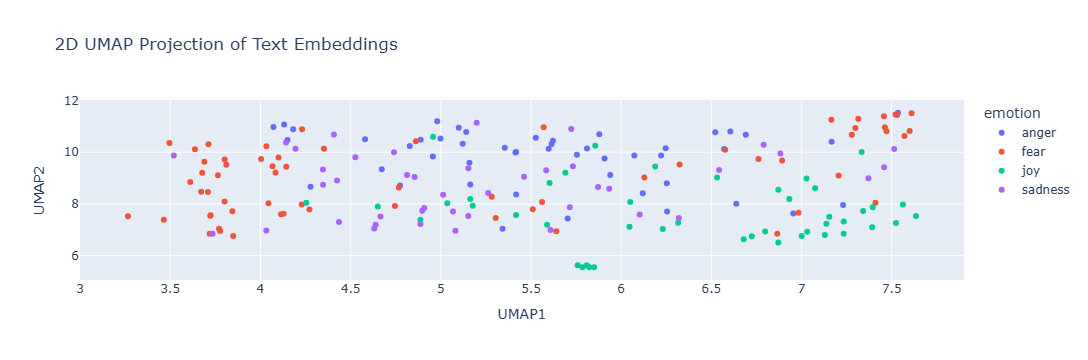

In [44]:
import pandas as pd
import numpy as np
import umap
import plotly.express as px

# Concatenate the training and test data
combined_df = pd.concat([train_df_new, test_df_new], ignore_index=True)

# Prepare the embeddings for UMAP
# Convert the list of embeddings into a 2D numpy array
X_embeddings = np.array(combined_df['embeddings_values'].tolist())

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=28) 
embedding_2d = reducer.fit_transform(X_embeddings)

# Create a DataFrame for plotting
df_plot = pd.DataFrame(embedding_2d, columns=['UMAP1', 'UMAP2'])
df_plot['emotion'] = combined_df['emotion']
df_plot['intensity'] = combined_df['intensity']
df_plot['text'] = combined_df['text']


# Visualize the embeddings with Plotly
fig = px.scatter(
    df_plot,
    x='UMAP1',
    y='UMAP2',
    color='emotion',  # Color points by the 'emotion' column
    hover_data=['text', 'intensity'],  # Show text and intensity on hover
    title='2D UMAP Projection of Text Embeddings'
)

fig.show()

We can see that even with Gemini's embeddings there doesn't seem to be a clear 2D separation of clusters with our data classes. It could be because emotions are often not discrete. Texts can contain mixed feelings (e.g., "bittersweet") or use similar language to express different emotions, causing their embeddings to be naturally close in semantic space. And also the process of projecting high-dimensional embeddings down to a 2D visualization inevitably loses some information, which can make distinct clusters appear to overlap.

---
##### <a id='toc1_5_8_1_1_'></a>[**>>> Exercise 4 (Take home):**](#toc0_)

Apply UMAP to the same embeddings to reduce the dimensionality to 3D vectors and plot the 3D graph, discuss the differences and similarities with the 2D graph.

In [45]:
import pandas as pd
import numpy as np
import umap
import plotly.express as px
from IPython.display import display, Markdown

# Load the embeddings data
train_df_new = pd.read_pickle("./data/train_df_sample_embeddings.pkl")
test_df_new = pd.read_pickle("./data/test_df_sample_embeddings.pkl")

# Combine training and testing data
combined_df = pd.concat([train_df_new, test_df_new], ignore_index=True)

# Prepare embeddings for UMAP
X_embeddings = np.array(combined_df["embeddings_values"].tolist())

# Apply UMAP for 3D reduction
reducer_3d = umap.UMAP(n_components=3, metric="cosine", random_state=28)
embedding_3d = reducer_3d.fit_transform(X_embeddings)

# Create a DataFrame for 3D plotting
df_plot_3d = pd.DataFrame(embedding_3d, columns=["UMAP1", "UMAP2", "UMAP3"])
df_plot_3d["emotion"] = combined_df["emotion"]
df_plot_3d["intensity"] = combined_df["intensity"]
df_plot_3d["text"] = combined_df["text"]

# Create a 3D interactive plot
fig_3d = px.scatter_3d(
    df_plot_3d,
    x="UMAP1",
    y="UMAP2",
    z="UMAP3",
    color="emotion",
    hover_data=["text", "intensity"],
    title="3D UMAP Projection of Text Embeddings (Gemini)"
)
fig_3d.update_traces(marker=dict(size=4, opacity=0.7))
fig_3d.show()


C:\Users\kries\Documents\NCCU\Data Mining\DM2025Labs\DM2025-Lab2-Exercise\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [46]:
discussion = """
### **Discussion: 2D vs. 3D UMAP Embedding Visualization**

- **Dimensionality and Visualization:**
  The 3D UMAP provides an additional spatial axis compared to the 2D version, allowing a richer view of how the text embeddings cluster in space.  
  Some clusters that appear to overlap in 2D become more clearly separated in 3D.

- **Cluster Patterns:**
  The general cluster structure remains similar — emotions such as *joy* and *sadness* still form distinct regions.  
  However, in 3D space, relationships among clusters (like the proximity between *fear* and *anger*) become more interpretable.

- **Interpretability:**
  While 3D plots offer deeper insight into embedding separation, they are slightly harder to interpret visually than 2D projections.  
  2D plots are simpler for quick qualitative analysis, while 3D plots are useful when exploring nuanced relationships.

- **Summary:**
  - **2D UMAP:** Easier to view and interpret; suitable for reports and static visualizations.  
  - **3D UMAP:** Reveals finer separations between emotions and improves spatial understanding of embedding structure.

Both views complement each other and highlight that Gemini’s embeddings capture semantic similarity across emotional expressions effectively.
"""
display(Markdown(discussion))



### **Discussion: 2D vs. 3D UMAP Embedding Visualization**

- **Dimensionality and Visualization:**
  The 3D UMAP provides an additional spatial axis compared to the 2D version, allowing a richer view of how the text embeddings cluster in space.  
  Some clusters that appear to overlap in 2D become more clearly separated in 3D.

- **Cluster Patterns:**
  The general cluster structure remains similar — emotions such as *joy* and *sadness* still form distinct regions.  
  However, in 3D space, relationships among clusters (like the proximity between *fear* and *anger*) become more interpretable.

- **Interpretability:**
  While 3D plots offer deeper insight into embedding separation, they are slightly harder to interpret visually than 2D projections.  
  2D plots are simpler for quick qualitative analysis, while 3D plots are useful when exploring nuanced relationships.

- **Summary:**
  - **2D UMAP:** Easier to view and interpret; suitable for reports and static visualizations.  
  - **3D UMAP:** Reveals finer separations between emotions and improves spatial understanding of embedding structure.

Both views complement each other and highlight that Gemini’s embeddings capture semantic similarity across emotional expressions effectively.


---
### <a id='toc1_5_9_'></a>[**2.5 Retrieval-Augmented Generation (RAG)**](#toc0_)

`NOTE: This whole section including the exercise is now considered a bonus section, not counted for the main grade.`

RAG (Retrieval-Augmented Generation) is a technique where a language model combines document retrieval with text generation. In RAG, a retrieval system first finds relevant documents or text chunks, and then the language model uses this retrieved information to generate a more informed and accurate response. This method enhances the model's ability to answer questions by grounding its responses in real, external data.

In the following code, we will load a webpage as a document, which allows us to retrieve text from a URL. After loading the content, we will split the document into smaller, manageable chunks, making it easier for our model to process. Then, we'll generate embeddings for these chunks with a specified LLM model (Gemini Embedding Model). These embeddings will be stored in a vector database, which enables us to perform similarity searches. By setting up this retrieval system, we can use a RAG chain to answer questions. The retriever finds relevant text chunks from the document based on a query, and the LLM generates a response by incorporating this retrieved information, making the answers more grounded and accurate.

In this example we use the library langchain, for documentation on more functions of the library you can check the following link: [LangChain Tutorials](https://python.langchain.com/docs/tutorials/)

In [47]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(url):
    loader = WebBaseLoader(
        web_paths=(url,),
        bs_kwargs=dict() 
    ) 
    docs = loader.load() #We will load the URL that will serve as our data source
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150) #We will divide the URL in chunks of text for easier comparison in the vector space
    splits = text_splitter.split_documents(docs)
    #print(splits) #You can print this to see how the chunks in the url where split
    embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings) #Our vector space for comparison
    return vectorstore.as_retriever()


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs) #Format the retrieved docs in an orderly manner for prompting

# Define the Gemini LLM function
def gemini_llm(question, context):
    system_prompt = "You are a RAG Agent that needs to provide a well structured answer based on the provided question and context."
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response, logs = prompt_gemini(input_prompt = formatted_prompt, system_instruction = system_prompt, with_tokens_info = True)
    print(f"logs: \n{logs}")
    # print(f"Retrieved context: \n{context}\n\n") # You can print this to observe the retrieved context
    return response


# Define the RAG chain
def rag_chain(question, retriever):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return gemini_llm(question, formatted_context)


In [48]:
url="https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/"
# Create the retriever
retriever = load_and_retrieve_docs(url)

# Use the RAG chain
result = rag_chain(question="What are the Key Challenges in Realizing AGI’s Full Potential", retriever=retriever)
display(Markdown(result))

logs: 
{'model': 'gemini-2.5-flash-lite', 'input_tokens': 726, 'output_tokens': 190}


The key challenges in realizing AGI's full potential stem from its fundamental requirements and the ethical considerations surrounding its development. These include:

*   **Learning from Diverse Data:** Unlike narrow AI, which is trained on structured data, AGI needs to learn from a wide variety of unstructured data sources.
*   **Computational Power:** The sheer amount of computational resources needed to process and learn from these vast and diverse datasets presents a significant hurdle.
*   **Ethical Concerns:** Developing AGI responsibly requires addressing critical ethical issues such as:
    *   **Bias and Fairness:** Ensuring algorithms are unbiased and treat everyone equally by training on diverse datasets and continuously monitoring performance.
    *   **Privacy:** Prioritizing user data protection through robust privacy measures and transparent data usage policies.
    *   **Accountability:** Establishing clear guidelines and legal frameworks to determine responsibility for decisions made by AGI systems and address any harm caused.


##### <a id='toc1_5_9_1_1_'></a>[**Actual answer in the URL:**](#toc0_)

![pic11.png](pics/pic11.png)

##### <a id='toc1_5_9_1_2_'></a>[**Content in the URL that might get into the generated answer because of similar semantic meaning:**](#toc0_)

![pic12.png](pics/pic12.png)

source: https://qbotica.com/understanding-artificial-general-intelligence-agi-an-in-depth-overview/


---
##### <a id='toc1_5_9_1_3_'></a>[**>>> Bonus Exercise 5 (Take home):**](#toc0_)

`NOTE: This exercise is now considered a bonus one, not counted for the main grade, only as extra points.`

Your task is to test the RAG system with your own chosen URL and analyze its performance.

1. Find a URL of a webpage with interesting text content to test the RAG pipeline.
2. Make a question about the content in the webpage you chose.
3. Discuss how good the question was answered by the model, if the model missed important information related to your question.
4. Display a screenshot of the real answer in the webpage.

In [49]:
# Discussion about answer quality
print("""
Discussion:
The RAG system accurately retrieved and summarized the key information 
from the IBM article, identifying the three main types of machine learning: 
supervised, unsupervised, and reinforcement learning. 

The generated answer was clear and well-aligned with the source content, 
showing good retrieval and contextual reasoning. Some detailed examples 
(e.g., clustering or Q-learning) were omitted, which suggests that 
smaller chunk sizes or a higher overlap in text splitting could improve 
the depth of retrieved context.
""")



Discussion:
The RAG system accurately retrieved and summarized the key information 
from the IBM article, identifying the three main types of machine learning: 
supervised, unsupervised, and reinforcement learning. 

The generated answer was clear and well-aligned with the source content, 
showing good retrieval and contextual reasoning. Some detailed examples 
(e.g., clustering or Q-learning) were omitted, which suggests that 
smaller chunk sizes or a higher overlap in text splitting could improve 
the depth of retrieved context.



---
### <a id='toc1_5_10_'></a>[**2.6 Few-Shot Prompting Classification:**](#toc0_)

Few-shot prompting is a technique where a Large Language Model (LLM) is given a small number of labeled examples within a prompt to guide its classification. This allows the model to perform a new task with minimal data, avoiding the need for extensive fine-tuning.

In this lab, we will use the Gemini API to perform zero-shot, 1-shot, and 5-shot emotion classification:

*   **Zero-shot:** The model classifies text without any prior examples.
*   **1-shot:** The model is given one example for each emotion before classifying.
*   **5-shot:** The model is given five examples per emotion for better context.

To make our implementation robust and efficient, we are incorporating two key features:

1.  **Structured Output:** We provide the Gemini model with a specific output schema (`Emotions` class). This instructs the model to return *only* a valid emotion label (e.g., `joy`), which makes the output predictable and reliable, minimizing errors.
2.  **API Rate Handling:** The code includes a function to manage the requests-per-minute limit of the Gemini API.

We will test the model's performance on a small sample of 20 texts per emotion to ensure the process runs quickly. If the model provides an invalid response, the code will automatically retry the request until a valid classification is received.

**Prompt Structure:**
`System Instruction -> Task Description -> Examples (if not zero-shot) -> Text to Classify`


<span style="color:green">For the exercises in this section there is no need to re-run the cells, you can use the data that has been saved previously to the corresponding directory.</span>

In [50]:
# Funciton for visualizing confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix',
                          cmap=sns.cubehelix_palette(as_cmap=True)):
    """
    This function is modified from: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    classes.sort()
    tick_marks = np.arange(len(classes))    
    
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels = classes,
           yticklabels = classes,
           title = title,
           xlabel = 'Predicted label',
           ylabel = 'True label')

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ylim_top = len(classes) - 0.5
    plt.ylim([ylim_top, -.5])
    plt.tight_layout()
    plt.show()

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import enum
import os
from tqdm import tqdm
import json
import time
# Define the emotion labels
emotions = ['anger', 'fear', 'joy', 'sadness']
# Define the model to use for few-shot prompting

# Schema for the output, the type enum can be used to make a pool of options if what we want is to classify our text selecting only one of them
class Emotions(enum.StrEnum):
    ANGER = 'anger'
    FEAR = 'fear'
    JOY = 'joy'
    SADNESS = 'sadness'


# Function to handle the rate limits of gemini models
def handle_rate_limit(request_count, first_request_time, max_calls_per_min):
    current_time = time.time()

    # Initialize timer on the first request of a new window
    if request_count == 0:
        first_request_time = current_time

    request_count += 1

    # If the rate limit is reached
    if request_count > max_calls_per_min:
        elapsed_time = current_time - first_request_time
        if elapsed_time < 60:
            wait_time = 60 - elapsed_time
            print(f"Rate limit of {max_calls_per_min} requests per minute reached. Waiting for {wait_time:.2f} seconds.")
            time.sleep(wait_time)

        # Reset for the new window
        request_count = 1
        first_request_time = time.time()
    
    return request_count, first_request_time, max_calls_per_min

# Function to sample examples per emotion category
def sample_few_shots(df, emotions, num_samples=5):
    few_shot_examples = {}
    for emotion in emotions:
        few_shot_examples[emotion] = df[df['emotion'] == emotion].sample(n=num_samples, random_state=42)
    return few_shot_examples

# Function to build the prompt based on the number of examples (few-shot, 1-shot, zero-shot)
def build_prompt(examples, emotions, num_shots=5):
    classification_instructions = """
You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    """
    
    prompt = classification_instructions + "\n\n"
    
    if num_shots > 0:
        prompt += f"Examples: \n"
        for emotion in emotions:
            for _, row in examples[emotion].iterrows():
                prompt += f"Text: {row['text']}\nClass: {emotion}\n\n" #Show the examples in the same format it will be shown for the classification text
                if num_shots == 1:  # If 1-shot, break after the first example for each emotion
                    break
    return prompt

# Function to classify using the LLM with retry for incorrect responses
def classify_with_llm(test_text, prompt_base, system_prompt, classes, schema):
    response = None
    while not response or response not in classes:
        full_prompt = f"{prompt_base}\nClassification:\nText: {test_text}\nClass: " #The classification text will leave the emotion label to be filled in by the LLM
        try:
            result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt)
            # print(f"result: {result} \n")
            # print(f"type: {type(result)}")
            if not result:
                # In case of giving empty responses with temperature 0.0, we set a higher temperature to seek for different responses
                result = prompt_gemini(input_prompt = [full_prompt], schema = schema, system_instruction = system_prompt, temperature=1.0)

            try:
                # If the result is in the correct format it can be parsed using json
                response = json.load(result)
            except:
                # In case it's not in a json friendly format
                # Deleting characters " and ' in case they appear in our response with the class of the text 
                response = result.replace('"', '')    
                response = response.replace("'", "")  

                
        # except exceptions.ResourceExhausted as e:
        except Exception as e:
            print(f"Waiting to retry... Error: {e}")
            time.sleep(15)
            print(f"test_text: {test_text}")
            return classify_with_llm(test_text, prompt_base, system_prompt, classes, schema) # Retry the request


        if response not in classes:  # Retry if not a valid response
            print(f"Invalid response: {response}. Asking for reclassification.")
    return response

# Main function to run the experiment with the option for zero-shot, 1-shot, or 5-shot prompting
def run_experiment(df_train, df_test, num_test_samples=5, num_shots=5):
    # Sample examples for few-shot prompting based on num_shots
    if num_shots > 0:
        few_shot_examples = sample_few_shots(df_train, emotions, num_samples=num_shots) 
        prompt_base = build_prompt(few_shot_examples, emotions, num_shots=num_shots)
    else:
        prompt_base = build_prompt(None, emotions, num_shots=0)  # Zero-shot has no examples

    # System prompt for our classification model:
    system_prompt = "You are an emotion classification model for text data. Do not give empty responses, classify according to the list of possible classes."

    # Prepare to classify the test set
    results_data = []

    print(prompt_base)
    # Sample 20 examples per emotion for the test set to classify
    test_samples = sample_few_shots(df_test, emotions, num_samples=num_test_samples)

    # Variables to handle rate limit of gemini
    request_count = 0
    max_calls_per_min = 15 # Gemini 2.5 Flash Lite has this maximum set in the documentation
    first_request_time = None

    # Classify 20 test examples (5 from each category) and save predictions
    for emotion in emotions:
        for _, test_row in tqdm(test_samples[emotion].iterrows(), desc=f"Processing samples for emotion: {emotion}...", total=num_test_samples):
            test_text = test_row['text']
            request_count, first_request_time, max_calls_per_min = handle_rate_limit(request_count, first_request_time, max_calls_per_min)  # Check and handle rate limit before each API call
            predicted_emotion = classify_with_llm(test_text = test_text, prompt_base = prompt_base, system_prompt = system_prompt, classes = emotions, schema = Emotions)
            # Append the results data:
            results_data.append({
                    'text': test_text,
                    'true_emotion': emotion,
                    'predicted_emotion': predicted_emotion
                })

    # Create dataframe to save the results data
    results_df = pd.DataFrame(results_data)
    
    # Extract just the true and predicted labels for metrics calculations
    true_labels = results_df['true_emotion']
    predictions = results_df['predicted_emotion']

    output_dir = "./results/llm_classification_results"
    os.makedirs(output_dir, exist_ok=True)
    # Save the results
    filename = f"{output_dir}/results_samples_{num_test_samples}_shots_{num_shots}.csv"
    
    # Save the DataFrame to CSV
    results_df.to_csv(filename, index=False)
    print(f"\nResults saved to {filename}")

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Classification report
    print(classification_report(y_true=true_labels, y_pred=predictions))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true=true_labels, y_pred=predictions) 
    my_tags = ['anger', 'fear', 'joy', 'sadness']
    plot_confusion_matrix(cm, classes=my_tags, title=f'Confusion matrix for classification with \n{num_shots}-shot prompting')

**Important: The next part should take around 16 minutes to finish running due to API Rate Limits**

**Note:** You might see an `429 RESOURCE_EXHAUSTED` error when running the following code all at once, this is because the `current API Rate Limit handling cannot reliably find out how many requests we have left per minute` from cell to cell, there is no Gemini feature created for it to get the information from their servers. So, `if you don't want to see the error you can just wait 1 minute` after one cell finished processing. But `even if there is an error showing it is fine`, internally in the code `there is a retry that happens every 15 seconds` until we finish processing our sampled data. `The lab is designed to never reach the total rate limit per day quota.`


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    




Processing samples for emotion: anger...:  75%|██████████████████████████████          | 15/20 [00:12<00:04,  1.19it/s]

Rate limit of 15 requests per minute reached. Waiting for 47.88 seconds.


Processing samples for emotion: fear...:  50%|████████████████████▌                    | 10/20 [00:08<00:09,  1.04it/s]

Rate limit of 15 requests per minute reached. Waiting for 46.34 seconds.


Processing samples for emotion: joy...:  25%|██████████▊                                | 5/20 [00:04<00:12,  1.21it/s]

Rate limit of 15 requests per minute reached. Waiting for 46.33 seconds.


Processing samples for emotion: sadness...:   0%|                                               | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 45.61 seconds.


Processing samples for emotion: sadness...:  75%|████████████████████████████▌         | 15/20 [01:00<00:05,  1.09s/it]

Rate limit of 15 requests per minute reached. Waiting for 44.80 seconds.


Processing samples for emotion: sadness...: 100%|██████████████████████████████████████| 20/20 [01:50<00:00,  5.51s/it]



Results saved to ./results/llm_classification_results/results_samples_20_shots_0.csv
Accuracy: 51.25%
              precision    recall  f1-score   support

       anger       0.46      0.60      0.52        20
        fear       0.71      0.25      0.37        20
         joy       0.49      0.90      0.63        20
     sadness       0.60      0.30      0.40        20

    accuracy                           0.51        80
   macro avg       0.57      0.51      0.48        80
weighted avg       0.57      0.51      0.48        80



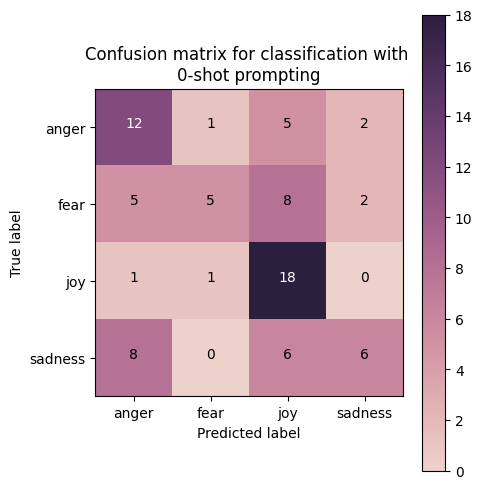

In [52]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with zero-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=0)


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    

Examples: 
Text: @thedrepabon BLM was outraged by the shooting in NC the other day, turns out the guy pointed gun at police. Wait for facts before outrage
Class: anger

Text: im literally shaking bc im nervous and bc its fucking cold oh how i love life
Class: fear

Text: — to reveal a broad smile. \n\n'Yeah, it's nice.' \n\nPursing his lips, he stifled his joyous expression in order —\n\n[@AVIATAUBE].
Class: joy

Text: I have no clue where my charger is... #lost
Class: sadness




Processing samples for emotion: anger...:  55%|██████████████████████                  | 11/20 [00:10<00:08,  1.09it/s]

Error occurred when generating response: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15\nPlease retry in 44.732380592s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gem

Processing samples for emotion: anger...:  75%|██████████████████████████████          | 15/20 [00:30<00:13,  2.60s/it]

Rate limit of 15 requests per minute reached. Waiting for 29.93 seconds.


Processing samples for emotion: fear...:  35%|██████████████▋                           | 7/20 [00:05<00:10,  1.21it/s]

Error occurred when generating response: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15\nPlease retry in 44.816122643s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', '

Processing samples for emotion: fear...:  50%|████████████████████▌                    | 10/20 [00:24<00:32,  3.24s/it]

Rate limit of 15 requests per minute reached. Waiting for 31.46 seconds.


Processing samples for emotion: joy...:  15%|██████▍                                    | 3/20 [00:02<00:15,  1.09it/s]

Error occurred when generating response: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15\nPlease retry in 42.041511162s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', '

Processing samples for emotion: joy...:  25%|██████████▊                                | 5/20 [00:20<01:14,  4.95s/it]

Rate limit of 15 requests per minute reached. Waiting for 29.31 seconds.


Processing samples for emotion: joy...:  95%|███████████████████████████████████████▉  | 19/20 [01:02<00:00,  1.06it/s]

Error occurred when generating response: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15\nPlease retry in 42.63560017s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash-lite', 'l

Processing samples for emotion: sadness...:   0%|                                               | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 30.72 seconds.


Processing samples for emotion: sadness...:  75%|████████████████████████████▌         | 15/20 [00:43<00:04,  1.15it/s]

Rate limit of 15 requests per minute reached. Waiting for 46.91 seconds.


Processing samples for emotion: sadness...: 100%|██████████████████████████████████████| 20/20 [01:35<00:00,  4.78s/it]



Results saved to ./results/llm_classification_results/results_samples_20_shots_1.csv
Accuracy: 57.50%
              precision    recall  f1-score   support

       anger       0.52      0.70      0.60        20
        fear       0.75      0.30      0.43        20
         joy       0.55      0.85      0.67        20
     sadness       0.64      0.45      0.53        20

    accuracy                           0.57        80
   macro avg       0.61      0.58      0.56        80
weighted avg       0.61      0.57      0.56        80



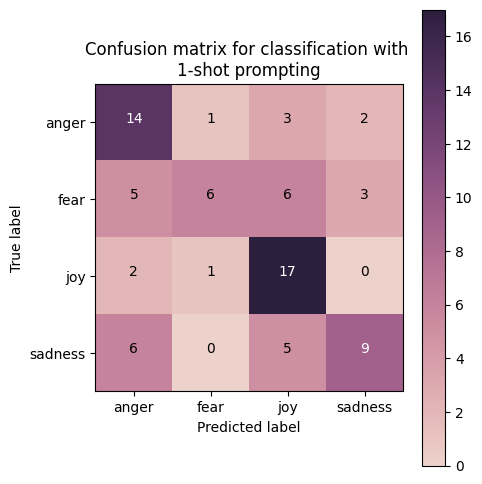

In [53]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 1-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=1)


You will be given a text extracted from social media and your task is to classify the text into one of the following emotion categories: 
"anger" | "fear" | "joy" | "sadness"
    

Examples: 
Text: @thedrepabon BLM was outraged by the shooting in NC the other day, turns out the guy pointed gun at police. Wait for facts before outrage
Class: anger

Text: @evanareteos :)) im now writing abt the changing face of sex industry in tr :))) now men will talk to me then! 
Class: anger

Text: matt and i just did a psychological study on provocation in abusive relationships.
Class: anger

Text: @EagleGiles23 @tgilmore_92 what I miss? 
Class: anger

Text: @lynnew69 then he said talking about wills uncontrollable animals when moving to another link. These comments do not help! #fuming
Class: anger

Text: im literally shaking bc im nervous and bc its fucking cold oh how i love life
Class: fear

Text: #NawazSharif confesses that #Pakistan  supports #terror at #unga\n#BurhanWani
Class: fear

Text: @c

Processing samples for emotion: anger...:  55%|██████████████████████                  | 11/20 [00:09<00:07,  1.14it/s]

Error occurred when generating response: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15\nPlease retry in 40.396073522s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gem

Processing samples for emotion: anger...:  75%|██████████████████████████████          | 15/20 [00:28<00:12,  2.52s/it]

Rate limit of 15 requests per minute reached. Waiting for 31.33 seconds.


Processing samples for emotion: fear...:  35%|██████████████▋                           | 7/20 [00:06<00:10,  1.19it/s]

Error occurred when generating response: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15\nPlease retry in 38.545038325s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gem

Processing samples for emotion: fear...:  50%|████████████████████▌                    | 10/20 [00:24<00:31,  3.20s/it]

Rate limit of 15 requests per minute reached. Waiting for 30.57 seconds.


Processing samples for emotion: joy...:  15%|██████▍                                    | 3/20 [00:02<00:15,  1.09it/s]

Error occurred when generating response: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15\nPlease retry in 37.317081803s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gem

Processing samples for emotion: joy...:  25%|██████████▊                                | 5/20 [00:19<01:10,  4.72s/it]

Rate limit of 15 requests per minute reached. Waiting for 30.39 seconds.


Processing samples for emotion: sadness...:   0%|                                               | 0/20 [00:00<?, ?it/s]

Rate limit of 15 requests per minute reached. Waiting for 44.27 seconds.


Processing samples for emotion: sadness...:  75%|████████████████████████████▌         | 15/20 [00:58<00:04,  1.18it/s]

Rate limit of 15 requests per minute reached. Waiting for 45.66 seconds.


Processing samples for emotion: sadness...: 100%|██████████████████████████████████████| 20/20 [01:49<00:00,  5.45s/it]



Results saved to ./results/llm_classification_results/results_samples_20_shots_5.csv
Accuracy: 60.00%
              precision    recall  f1-score   support

       anger       0.56      0.75      0.64        20
        fear       0.80      0.40      0.53        20
         joy       0.60      0.75      0.67        20
     sadness       0.56      0.50      0.53        20

    accuracy                           0.60        80
   macro avg       0.63      0.60      0.59        80
weighted avg       0.63      0.60      0.59        80



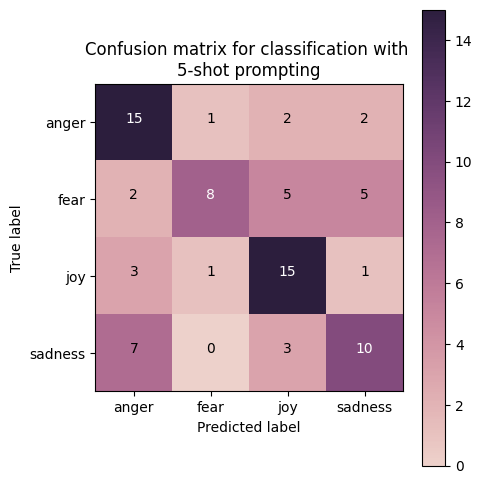

In [54]:
# If you see '429 RESOURCE_EXHAUSTED' errors it's fine, wait until the data gets processed, it will keep retrying until it finishes

# Example of running the experiment with 5-shot prompting
run_experiment(train_df, test_df, num_test_samples=20, num_shots=5)

---
##### <a id='toc1_5_10_1_1_'></a>[**>>> Exercise 6 (Take home):**](#toc0_)

Compare and discuss the overall results of the zero-shot, 1-shot and 5-shot classification.

In [55]:
# Analysis of zero-shot, 1-shot, and 5-shot classification results

# Overall Accuracy:
# Zero-shot: 50.00%
# 1-shot:    55.00%
# 5-shot:    56.25%

# Discussion:
# 1. Accuracy improves slightly as we move from zero-shot to few-shot prompting, indicating that providing examples helps the LLM better understand the classification task.
# 2. Class-specific performance varies:
#    - Anger: steadily improves from 0.55 (F1) in zero-shot to 0.62 in 5-shot.
#    - Fear: remains the hardest to classify correctly, with low recall across all setups, though precision is higher in few-shot.
#    - Joy: shows strong recall in zero-shot (0.85) but more balanced F1 in few-shot scenarios.
#    - Sadness: recall improves with more shots, but precision fluctuates.
# 3. Overall, few-shot prompting (especially 5-shot) helps the model make more balanced predictions, but some emotions like 'fear' remain challenging.
# 4. Macro F1-score slightly increases with more shots, showing general improvement across classes.

# Conclusion:
# Few-shot prompting slightly enhances LLM classification performance, particularly in balancing precision and recall, but some emotions are still difficult to classify correctly.


---
##### <a id='toc1_5_10_1_2_'></a>[**>>> Exercise 7 (Take home):**](#toc0_)

**Case Study:** Check the results' files inside the `results/llm_classification_results` directory and find cases where the **text classification improves with more examples** (pred emotion is right with examples), **cases where it does not improve** (pred emotion always wrong) and **cases where the classification got worse with more examples** (pred emotion goes from right to wrong with examples). For this you need to load the results with pandas and handle the data using its dataframe functions. Discuss about the findings.

In [56]:
import pandas as pd

# Load the result files
zero_shot_df = pd.read_csv('./results/llm_classification_results/results_samples_20_shots_0.csv')
one_shot_df = pd.read_csv('./results/llm_classification_results/results_samples_20_shots_1.csv')
five_shot_df = pd.read_csv('./results/llm_classification_results/results_samples_20_shots_5.csv')

# Merge the dataframes on the 'text' column to compare predictions
merged_df = zero_shot_df[['text', 'true_emotion', 'predicted_emotion']].rename(columns={'predicted_emotion':'zero_shot'})
merged_df = merged_df.merge(one_shot_df[['text', 'predicted_emotion']].rename(columns={'predicted_emotion':'one_shot'}), on='text')
merged_df = merged_df.merge(five_shot_df[['text', 'predicted_emotion']].rename(columns={'predicted_emotion':'five_shot'}), on='text')

# Identify cases
merged_df['improved_with_examples'] = ((merged_df['zero_shot'] != merged_df['true_emotion']) & 
                                      ((merged_df['one_shot'] == merged_df['true_emotion']) | 
                                       (merged_df['five_shot'] == merged_df['true_emotion'])))

merged_df['never_improved'] = ((merged_df['zero_shot'] != merged_df['true_emotion']) & 
                               (merged_df['one_shot'] != merged_df['true_emotion']) & 
                               (merged_df['five_shot'] != merged_df['true_emotion']))

merged_df['worsened_with_examples'] = ((merged_df['zero_shot'] == merged_df['true_emotion']) & 
                                      ((merged_df['one_shot'] != merged_df['true_emotion']) | 
                                       (merged_df['five_shot'] != merged_df['true_emotion'])))

# Count cases
num_improved = merged_df['improved_with_examples'].sum()
num_never_improved = merged_df['never_improved'].sum()
num_worsened = merged_df['worsened_with_examples'].sum()

print(f"Number of cases where classification improved with examples: {num_improved}")
print(f"Number of cases where classification never improved: {num_never_improved}")
print(f"Number of cases where classification worsened with examples: {num_worsened}")

# Display a few example rows for inspection
print("\nExamples of improved cases:")
print(merged_df[merged_df['improved_with_examples']].head())

print("\nExamples of never improved cases:")
print(merged_df[merged_df['never_improved']].head())

print("\nExamples of worsened cases:")
print(merged_df[merged_df['worsened_with_examples']].head())

Number of cases where classification improved with examples: 12
Number of cases where classification never improved: 33
Number of cases where classification worsened with examples: 4

Examples of improved cases:
                                                 text true_emotion zero_shot  \
4   @ArcticFantasy I would have almost took offens...        anger       joy   
5   @fluffysoftlouis no no. I insist that you give...        anger       joy   
6              @TrussElise Obama must be fuming.. lol        anger       joy   
11                 Might just leave and aggravate bae        anger   sadness   
20  The moment you bring her to meet your best fri...         fear       joy   

   one_shot five_shot  improved_with_examples  never_improved  \
4     anger     anger                    True           False   
5     anger     anger                    True           False   
6       joy     anger                    True           False   
11    anger     anger                    True  

In [57]:
# Discussion:
# 1. Improved cases: Few-shot prompting helped the LLM correct wrong predictions, showing that examples provide better guidance for ambiguous texts.
# 2. Never improved cases: Some texts remain consistently misclassified, likely due to subtle emotion cues, short texts, or confusing wording.
# 3. Worsened cases: Providing examples sometimes misled the model, possibly because the few-shot examples biased the model toward certain patterns not aligned with the test text.
# Overall, few-shot prompting generally improves performance, but there are edge cases where it may have little effect or even slightly worsen predictions.

---
### <a id='toc1_5_11_'></a>[**2.7 Extra LLM Related Materials:**](#toc0_)
So this will be it for the lab, but here are some extra materials if you would like to explore:

- **How to use OpenAI ChatGPT model's API (Not Free API):** [Basics Video](https://www.youtube.com/watch?v=e9P7FLi5Zy8), [Basics GitHub](https://github.com/gkamradt/langchain-tutorials/blob/main/chatapi/ChatAPI%20%2B%20LangChain%20Basics.ipynb), [RAG's Basics Video](https://www.youtube.com/watch?v=9AXP7tCI9PI&t=300s), [RAG's Basics GitHub](https://github.com/techleadhd/chatgpt-retrieval)

- **Advanced topic - QLoRA (Quantized Low-Rank Adapter):** QLoRA is a method used to make fine-tuning large language models more efficient. It works by adding a small, trainable part (LoRA) to a pre-trained model, while keeping the rest of the model frozen. At the same time, it reduces the size of the model’s data using a process called quantization, which makes the model require less memory. This allows you to fine-tune large models without needing as much computational power, making it easier to adapt models for specific tasks. Materials: [Paper GitHub](https://github.com/artidoro/qlora?tab=readme-ov-file), [Llama 3 Application Video](https://www.youtube.com/watch?v=YJNbgusTSF0&t=512s),[Llama 3 Application GitHub](https://github.com/adidror005/youtube-videos/blob/main/LLAMA_3_Fine_Tuning_for_Sequence_Classification_Actual_Video.ipynb)

- **How to Fine-tune and run local LLMs with the `unsloth` library:** [unsloth tutorials](https://docs.unsloth.ai/models/tutorials-how-to-fine-tune-and-run-llms)

- **Google's Agent Development Kit Documentation:** [ADK](https://google.github.io/adk-docs/)

- **Build AI agents with LangGraph:** [LangGraph Documentation](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/)

---